In [18]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import visuals as vs
from sklearn.decomposition import PCA
plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe lab_events 


In [3]:
data = pd.DataFrame.from_csv('SEPSIS_LABEVENTS_FIRST_py.csv')
data.head()

hadm_id  icustay_id  mort_icu  mort_hosp diagnosis  aniongap_1st  \
subject_id                                                                     
21           111970      216859         1          1    SEPSIS          19.0   
94           183686      229012         0          0    SEPSIS          13.0   
157          107880      264885         0          0    SEPSIS          22.0   
166          128219      271863         1          1    SEPSIS          19.0   
188          191517      278679         0          0    SEPSIS          14.0   

            albumin_1st  bicarbonate_1st  bilirubin_1st  creatinine_1st  \
subject_id                                                                
21                  2.1             23.0            0.3             4.2   
94                  NaN             23.0            1.4             0.6   
157                 NaN             20.0            0.6             0.8   
166                 NaN             24.0            NaN             0.8   
188                 2.9             17.0            1.8             2.4   

             ...     magnesium_1st  phosphate_1st  platelet_1st  \
subject_id   ...                                                  
21           ...               1.5            4.4         275.0   
94           ...               1.4            2.1         162.0   
157          ...               2.3            4.4         255.0   
166          ...               NaN            NaN         341.0   
188          ...               1.0            3.3         266.0   

            potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  \
subject_id                                                                 
21                    3.8     31.7      1.7    18.1       137.0     49.0   
94                    2.5     31.0      1.0    12.0       132.0      8.0   
157                   4.9     30.1      1.2    13.3       135.0     15.0   
166                   3.7     22.8      1.2    13.5       142.0     20.0   
188                   5.0     32.7      1.2    13.7       133.0     31.0   

            wbc_1st  
subject_id           
21             30.5  
94              6.0  
157            52.0  
166            16.5  
188            16.7  

[5 rows x 25 columns]

In [ ]:
# code to reorder columns to create index and move subject id
cols = list(data.columns.values)
cols = cols[-1:] + cols[:-1]
cols
data = data[cols]
data.head()

In [4]:
data.dtypes

hadm_id              int64
icustay_id           int64
mort_icu             int64
mort_hosp            int64
diagnosis           object
aniongap_1st       float64
albumin_1st        float64
bicarbonate_1st    float64
bilirubin_1st      float64
creatinine_1st     float64
chloride_1st       float64
glucose_1st        float64
hematocrit_1st     float64
hemoglobin_1st     float64
lactate_1st        float64
magnesium_1st      float64
phosphate_1st      float64
platelet_1st       float64
potassium_1st      float64
ptt_1st            float64
inr_1st            float64
pt_1st             float64
sodium_1st         float64
bun_1st            float64
wbc_1st            float64
dtype: object

In [5]:
cols = list(data.columns)
print cols

['hadm_id', 'icustay_id', 'mort_icu', 'mort_hosp', 'diagnosis', 'aniongap_1st', 'albumin_1st', 'bicarbonate_1st', 'bilirubin_1st', 'creatinine_1st', 'chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'ptt_1st', 'inr_1st', 'pt_1st', 'sodium_1st', 'bun_1st', 'wbc_1st']


In [6]:
lab_measures = cols[5:]
print lab_measures

['aniongap_1st', 'albumin_1st', 'bicarbonate_1st', 'bilirubin_1st', 'creatinine_1st', 'chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'ptt_1st', 'inr_1st', 'pt_1st', 'sodium_1st', 'bun_1st', 'wbc_1st']


In [7]:
lab_measures.sort()
print lab_measures

['albumin_1st', 'aniongap_1st', 'bicarbonate_1st', 'bilirubin_1st', 'bun_1st', 'chloride_1st', 'creatinine_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'inr_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'pt_1st', 'ptt_1st', 'sodium_1st', 'wbc_1st']


In [8]:
lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }



In [9]:
'''
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


{'wbc_1st': '', 'bicarbonate_1st': 'mEq/L', 'phosphate_1st': 'mg/dL', 'hematocrit_1st': '%', 'chloride_1st': 'mEq/L', 'lactate_1st': 'mmol/L', 'potassium_1st': 'mEq/L', 'glucose_1st': 'mg/dL', 'creatinine_1st': 'mg/dL', 'magnesium_1st': 'mmol/L', 'aniongap_1st': 'mEq/L', 'pt_1st': '', 'hemoglobin_1st': 'g/dL', 'ptt_1st': 'sec', 'albumin_1st': 'g/dL', 'bun_1st': '', 'inr_1st': '', 'bilirubin_1st': 'mg/dL', 'sodium_1st': 'mmol/L', 'platelet_1st': 'K/uL'}


In [10]:
l = lab_measures[0]
ded = 0
print "number of non_survivors              = {}".format(data[l][data.mort_icu==1].dropna().count())
print "numver of survivors                  = {}".format(data[l][data.mort_icu==0].dropna().count())
print "median value of {} for non_survivors = {}".format(l,data[l][data.mort_icu==1].dropna().median())
print "median value of {} for survivors     = {}".format(l,data[l][data.mort_icu==0].dropna().median())
print "variance of {} for non_survivors     = {}".format(l,data[l][data.mort_icu==1].dropna().var())
print "variance of {} for survivors         = {}".format(l,data[l][data.mort_icu==0].dropna().var())
print "skewness of {} for non_survivors     = {}".format(l,data[l][data.mort_icu==1].dropna().skew())
print "variance of {} for survivors         = {}".format(l,data[l][data.mort_icu==0].dropna().skew())


number of non_survivors              = 137
numver of survivors                  = 687
median value of albumin_1st for non_survivors = 2.4
median value of albumin_1st for survivors     = 2.9
variance of albumin_1st for non_survivors     = 0.365112709317
variance of albumin_1st for survivors         = 0.465424438022
skewness of albumin_1st for non_survivors     = 0.0800886777727
variance of albumin_1st for survivors         = 0.287128916203


In [11]:
ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

print "kolmogorov smirnov test shows {}  with p-value of {}".format(ks_stat, p_val)


kolmogorov smirnov test shows 0.273855438328  with p-value of 4.76343027427e-08


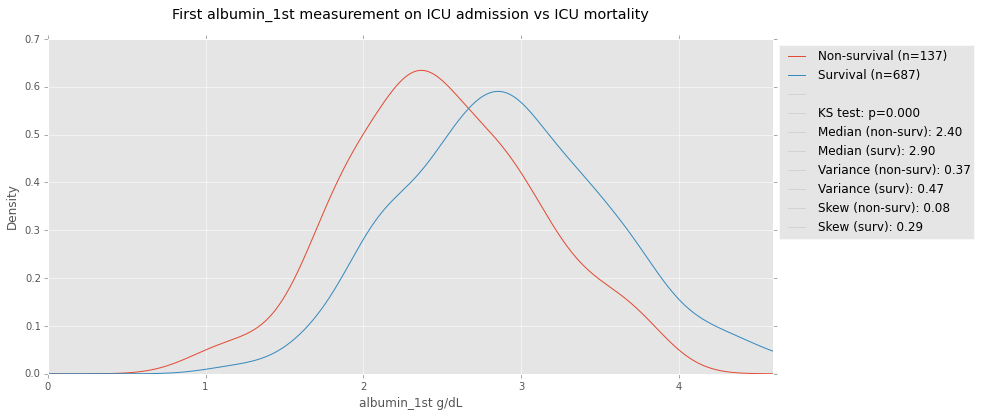

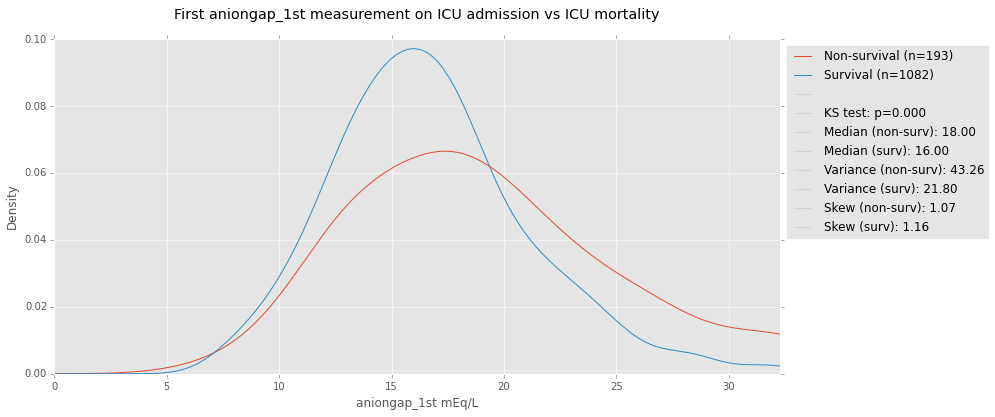

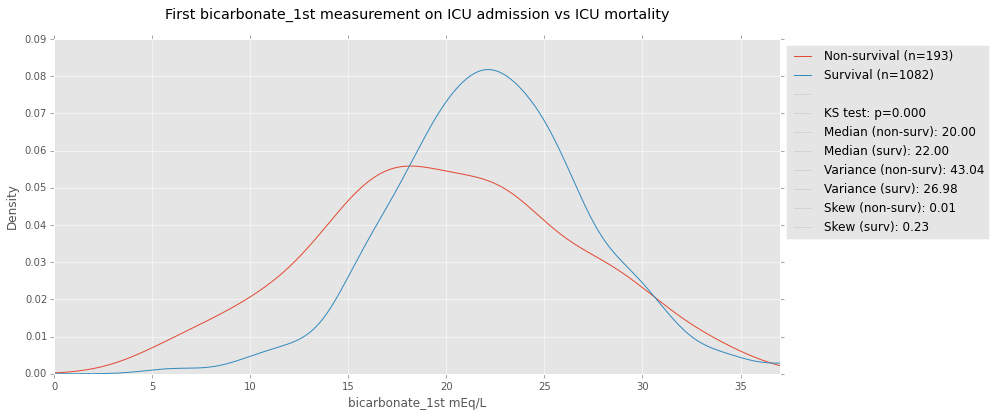

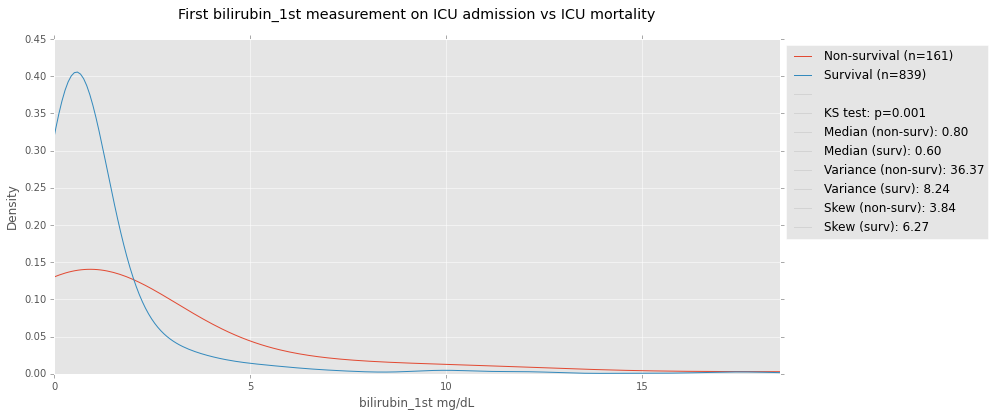

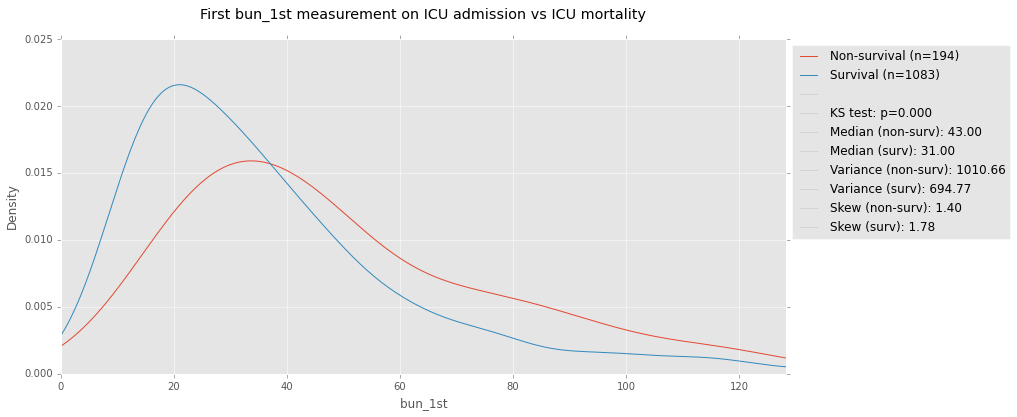

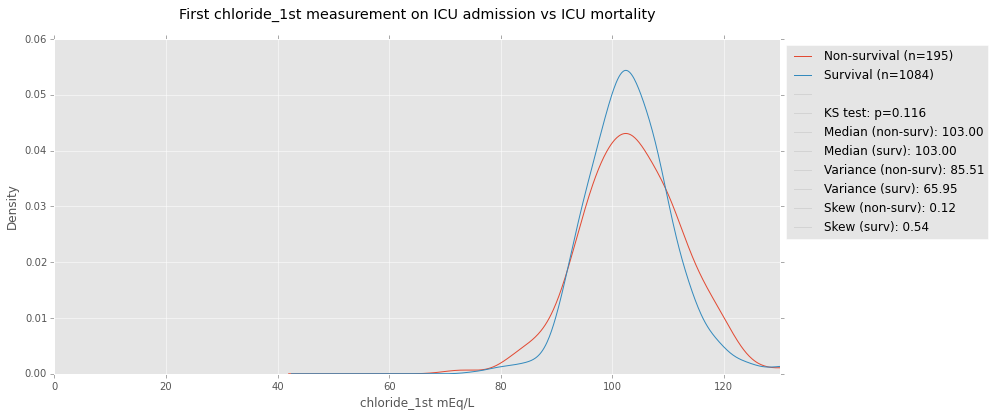

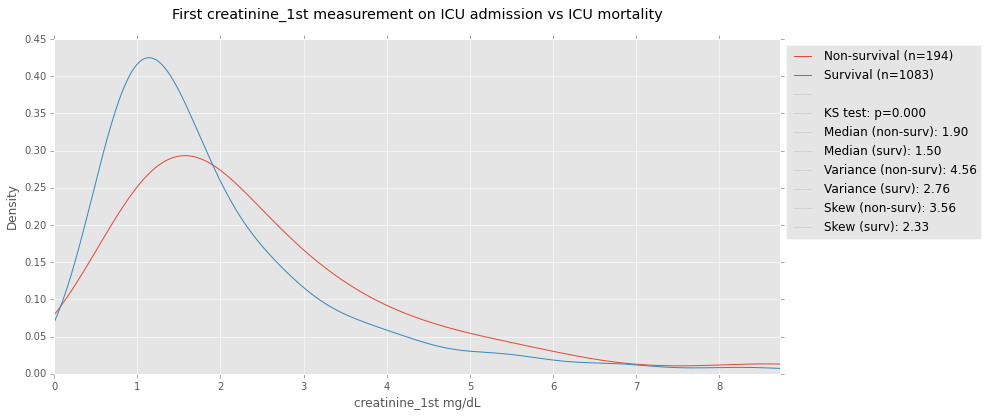

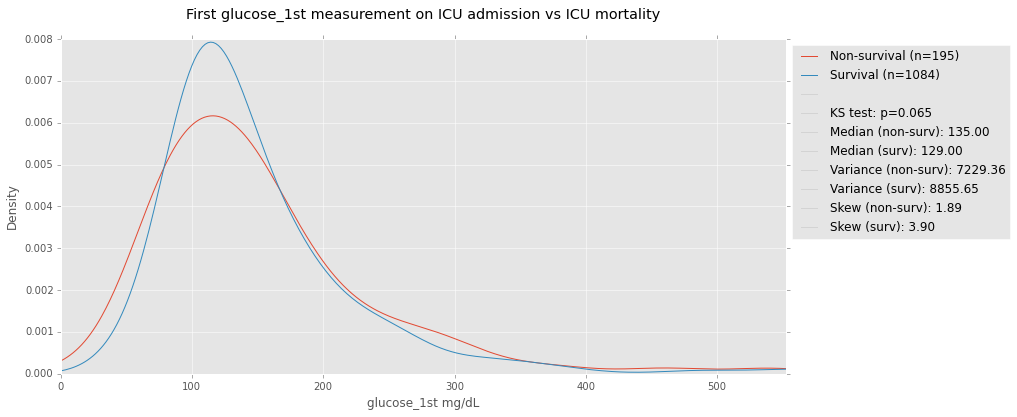

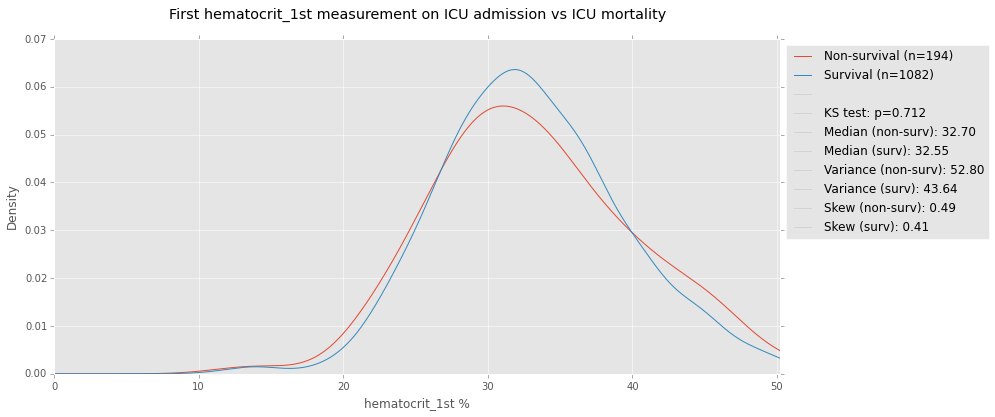

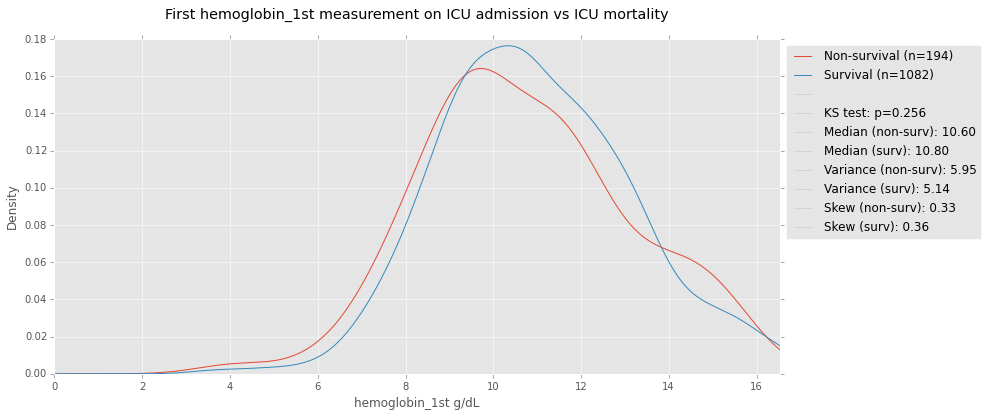

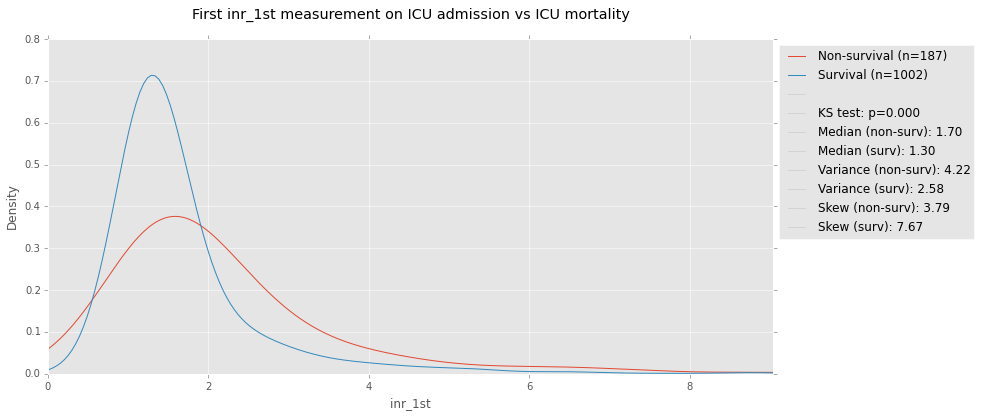

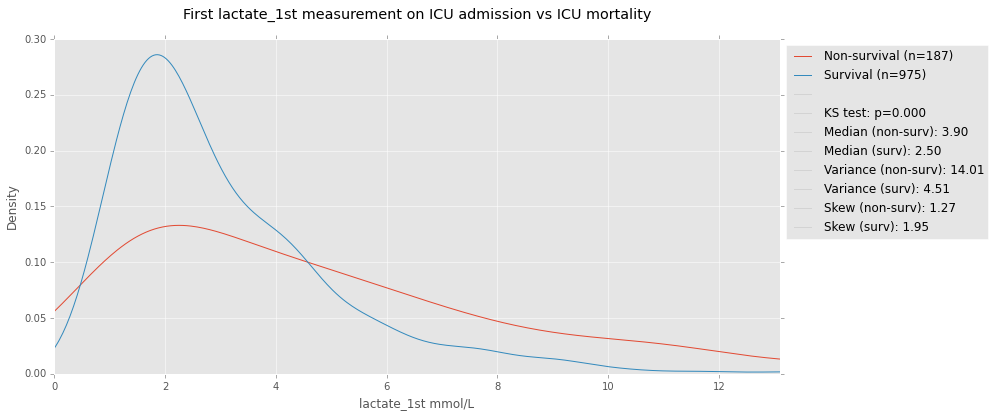

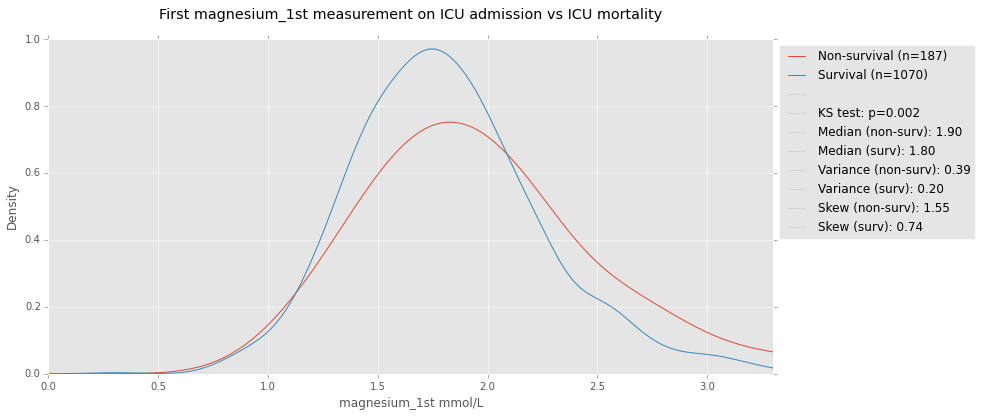

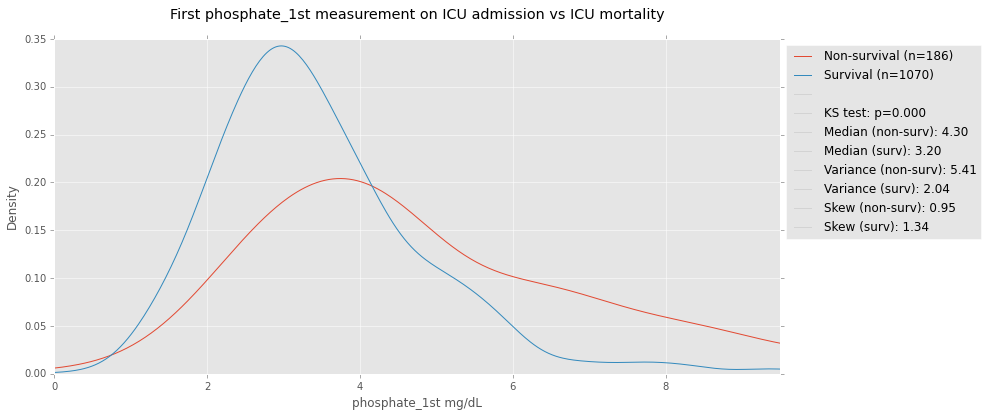

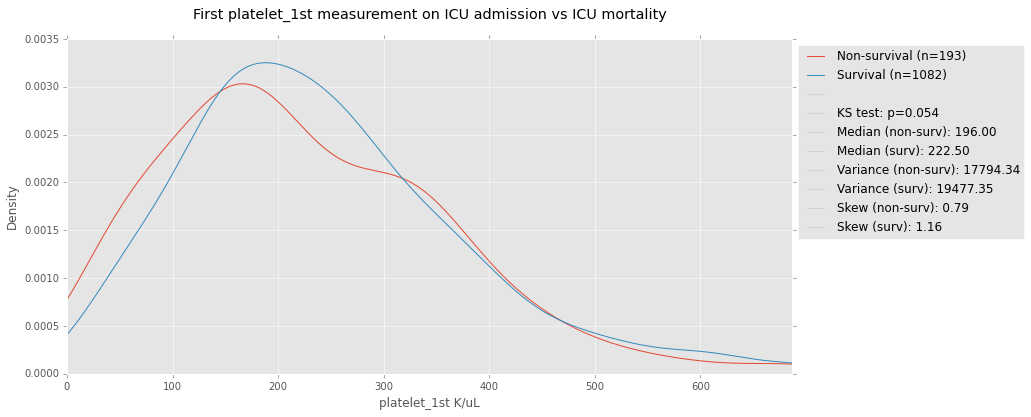

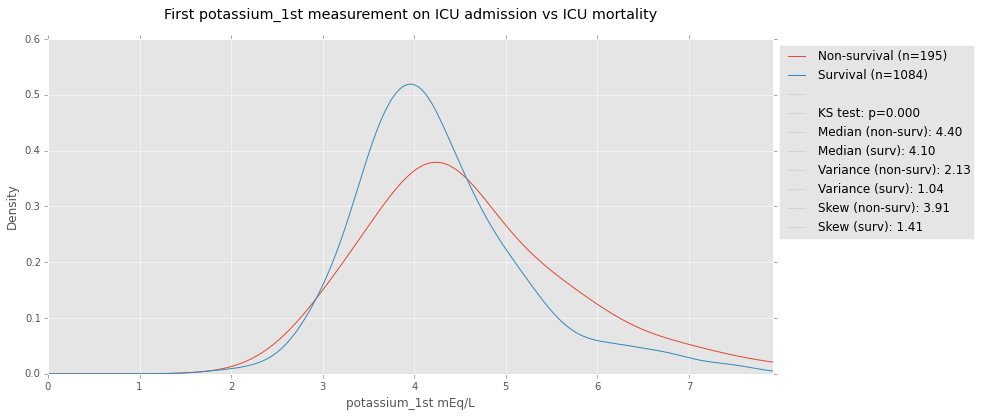

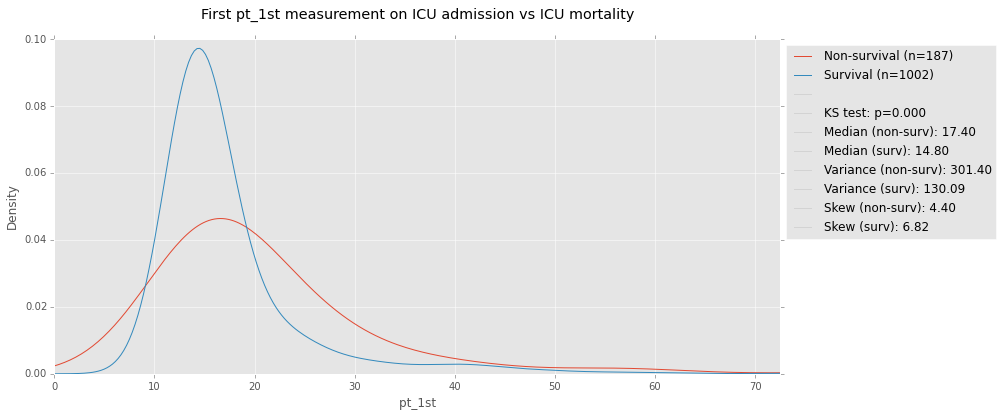

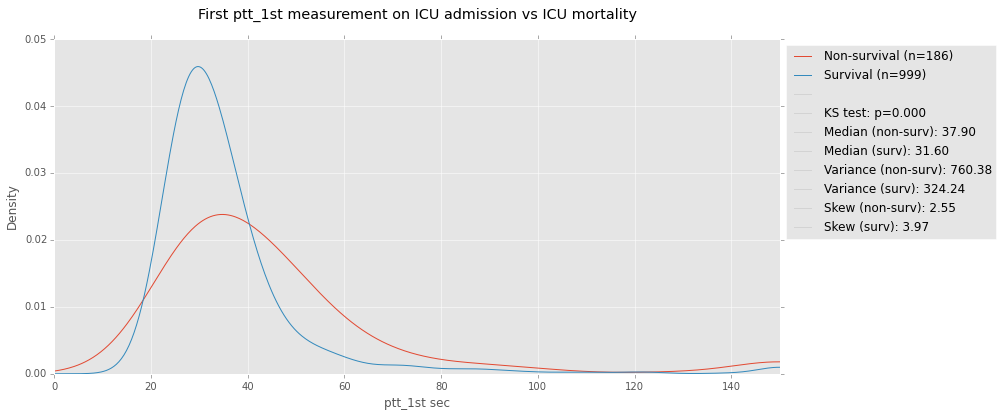

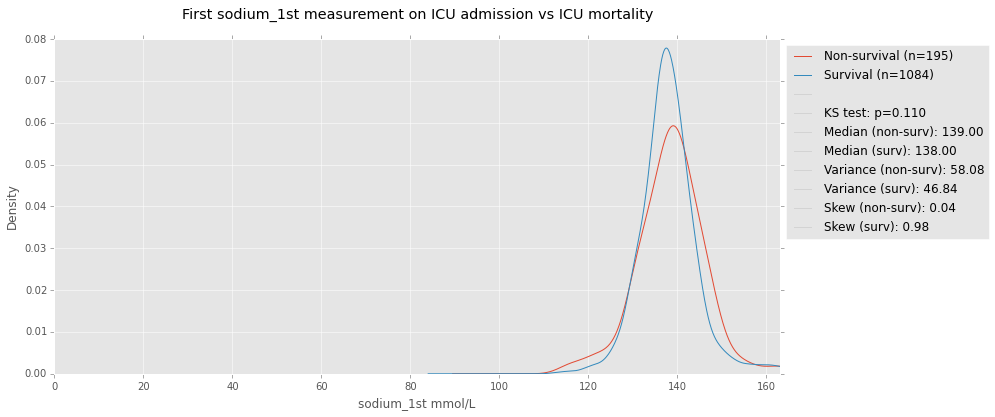

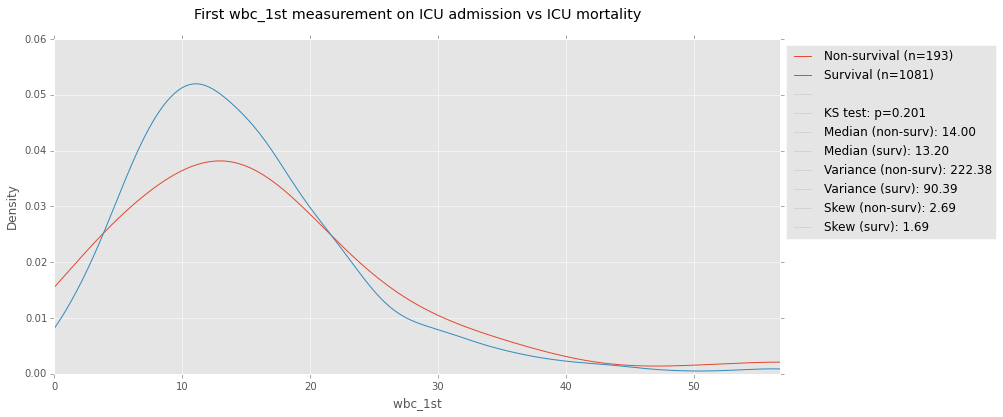

In [12]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

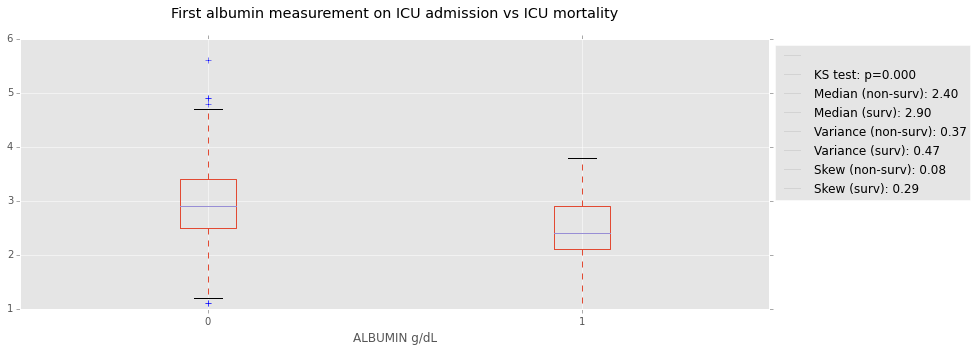

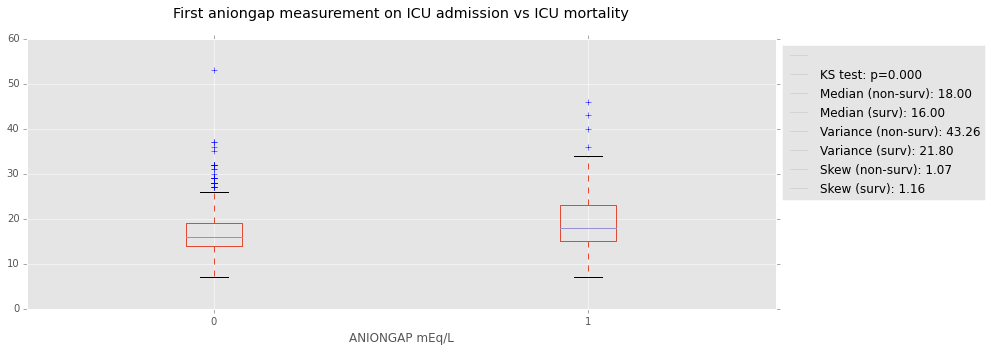

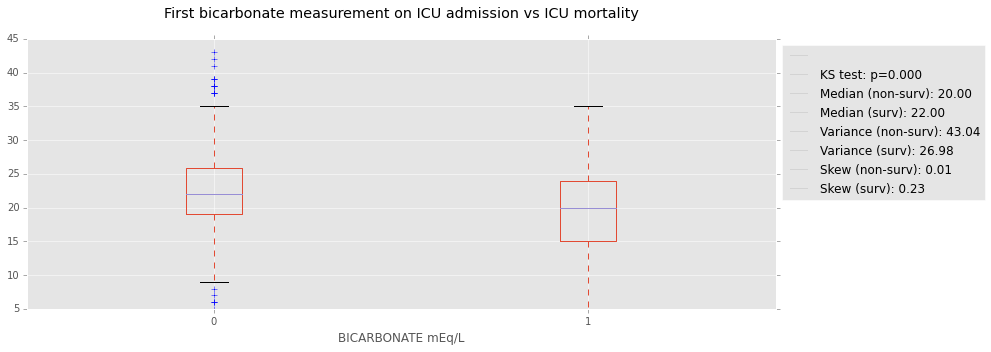

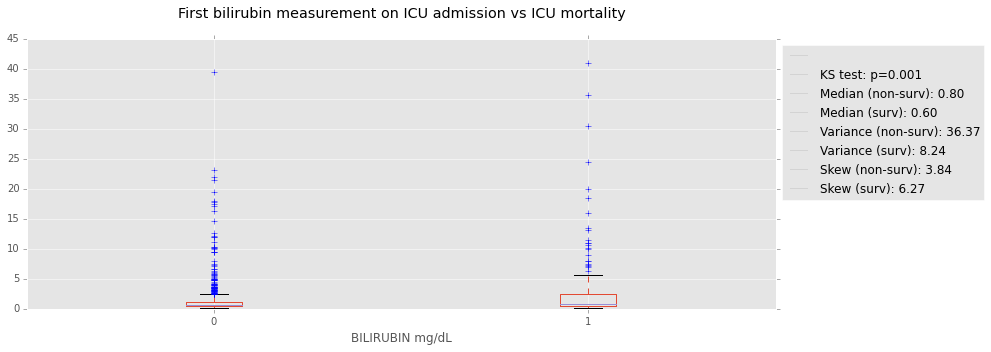

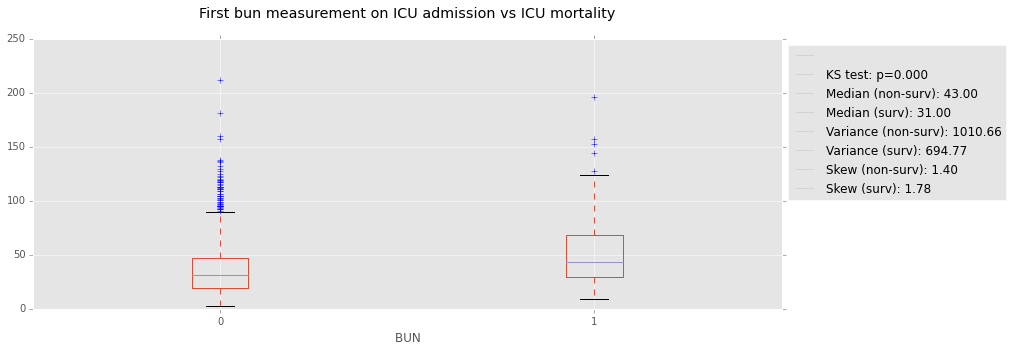

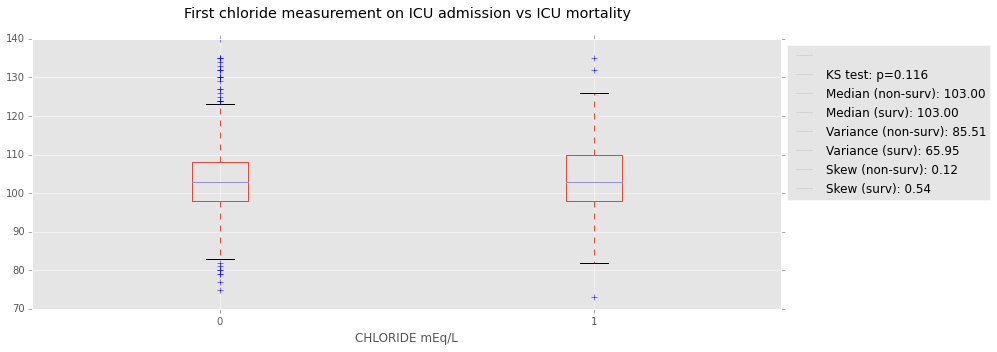

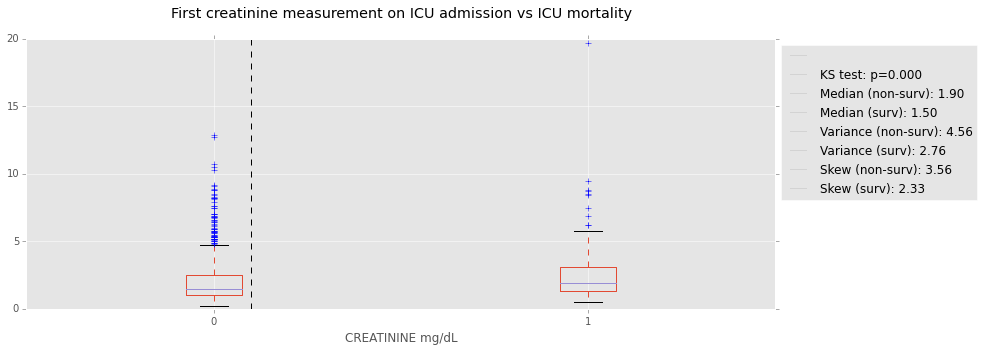

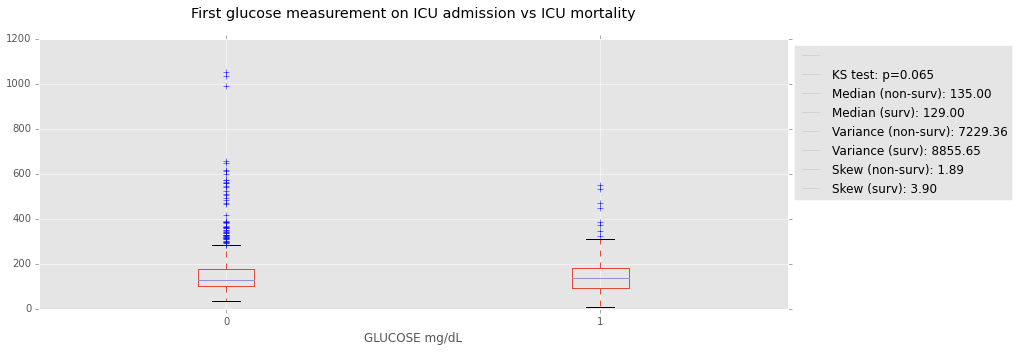

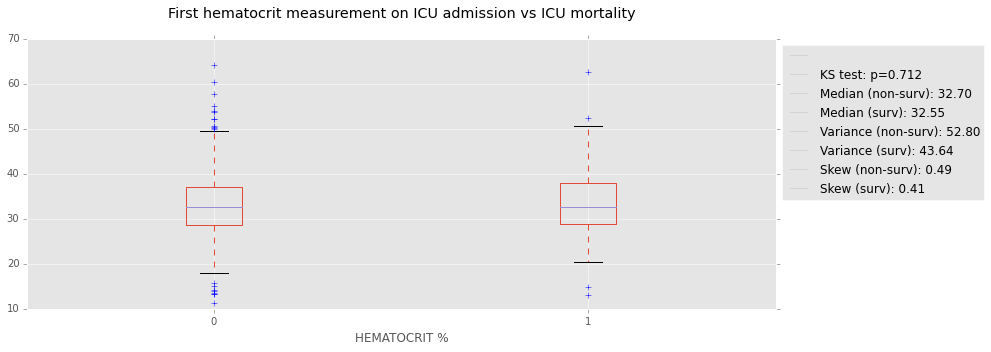

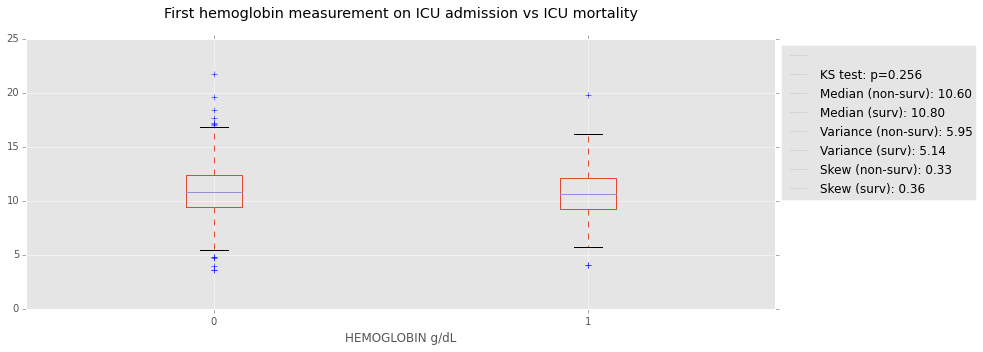

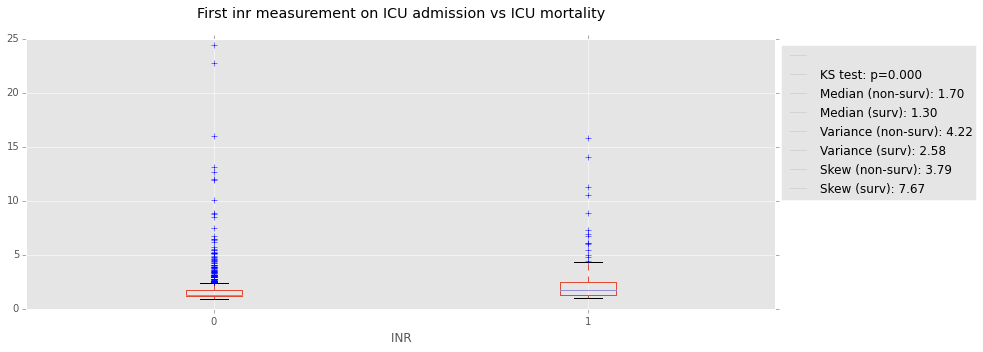

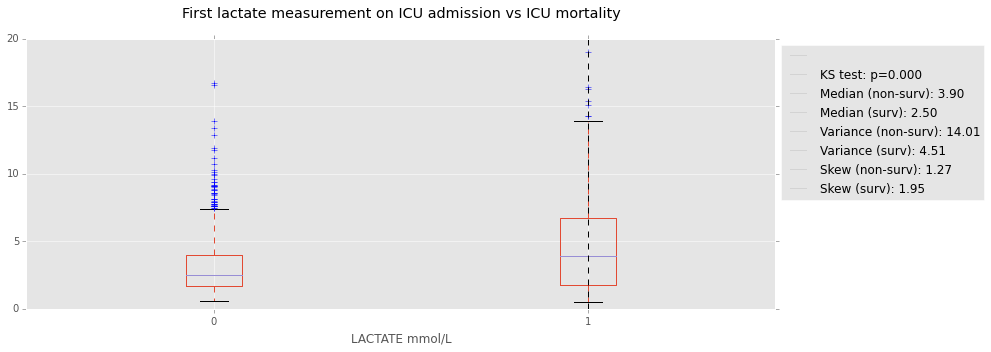

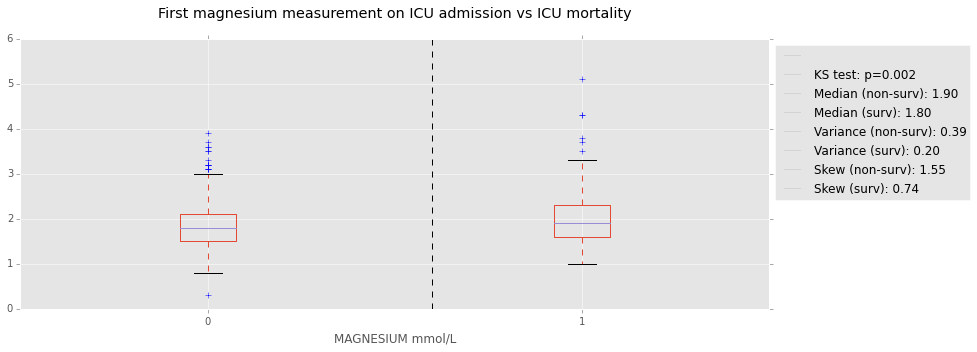

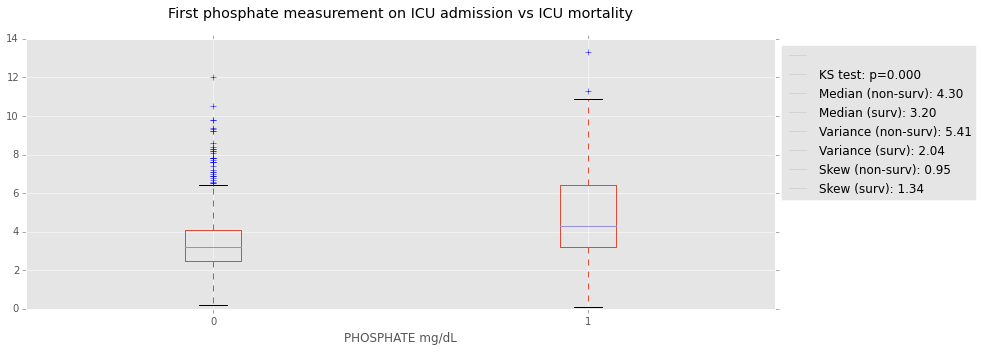

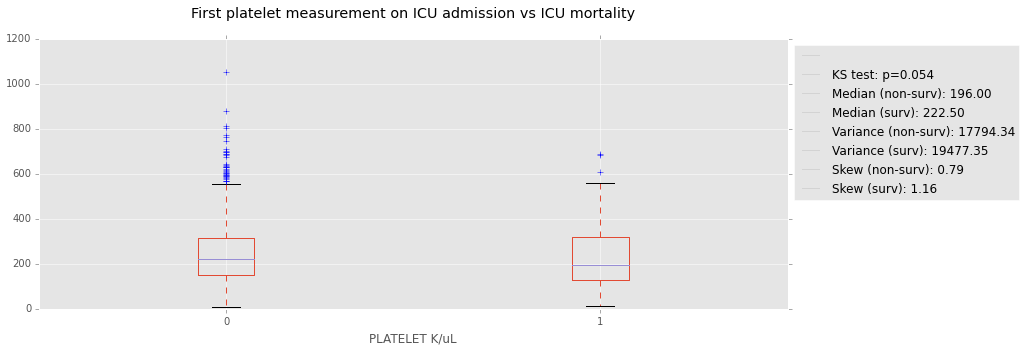

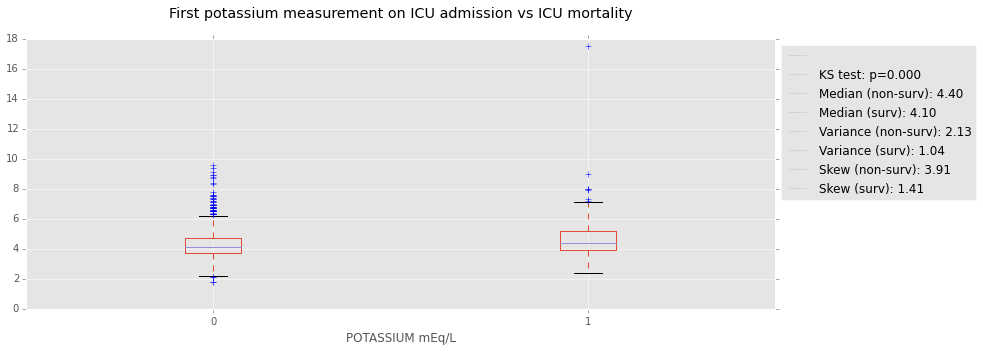

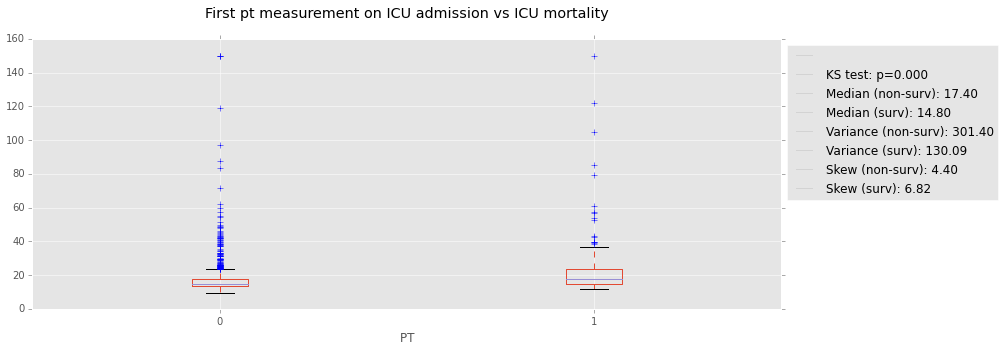

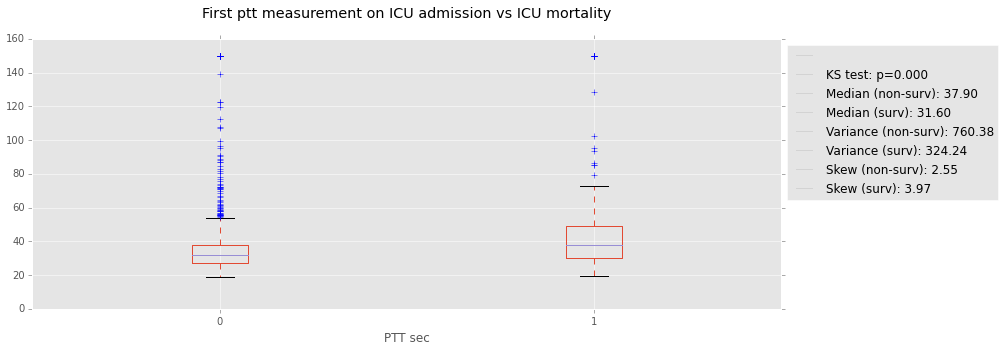

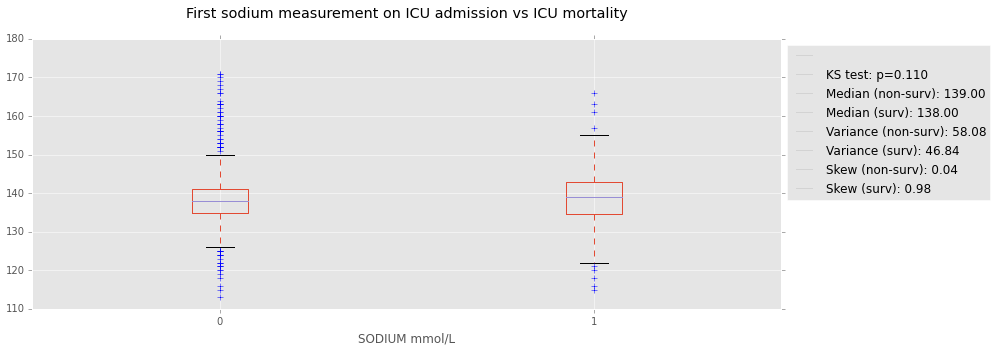

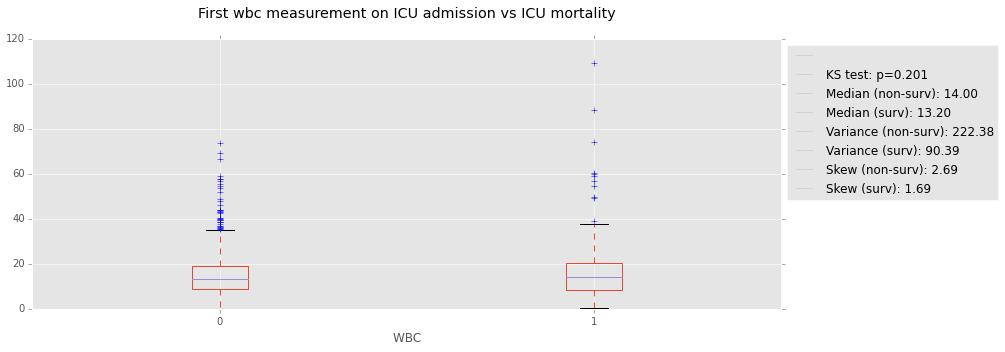

In [13]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
   #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

In [27]:
data.head()

hadm_id  icustay_id  mort_icu  mort_hosp diagnosis  aniongap_1st  \
subject_id                                                                     
21           111970      216859         1          1    SEPSIS          19.0   
94           183686      229012         0          0    SEPSIS          13.0   
157          107880      264885         0          0    SEPSIS          22.0   
166          128219      271863         1          1    SEPSIS          19.0   
188          191517      278679         0          0    SEPSIS          14.0   

            albumin_1st  bicarbonate_1st  bilirubin_1st  creatinine_1st  \
subject_id                                                                
21                  2.1             23.0            0.3             4.2   
94                  NaN             23.0            1.4             0.6   
157                 NaN             20.0            0.6             0.8   
166                 NaN             24.0            NaN             0.8   
188                 2.9             17.0            1.8             2.4   

               ...      phosphate_1st  platelet_1st  potassium_1st  ptt_1st  \
subject_id     ...                                                            
21             ...                4.4         275.0            3.8     31.7   
94             ...                2.1         162.0            2.5     31.0   
157            ...                4.4         255.0            4.9     30.1   
166            ...                NaN         341.0            3.7     22.8   
188            ...                3.3         266.0            5.0     32.7   

            inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  subject_id  
subject_id                                                             
21              1.7    18.1       137.0     49.0     30.5          21  
94              1.0    12.0       132.0      8.0      6.0          94  
157             1.2    13.3       135.0     15.0     52.0         157  
166             1.2    13.5       142.0     20.0     16.5         166  
188             1.2    13.7       133.0     31.0     16.7         188  

[5 rows x 26 columns]

In [61]:
data.shape

(1290, 25)

## code was to reset index from subject id
data.set_index(np.arange(data.shape[0]), inplace = True)
data.head()

In [31]:
cols = list(data.columns.values)
cols = cols[-1:] + cols[:-1]
cols

['subject_id',
 'hadm_id',
 'icustay_id',
 'mort_icu',
 'mort_hosp',
 'diagnosis',
 'aniongap_1st',
 'albumin_1st',
 'bicarbonate_1st',
 'bilirubin_1st',
 'creatinine_1st',
 'chloride_1st',
 'glucose_1st',
 'hematocrit_1st',
 'hemoglobin_1st',
 'lactate_1st',
 'magnesium_1st',
 'phosphate_1st',
 'platelet_1st',
 'potassium_1st',
 'ptt_1st',
 'inr_1st',
 'pt_1st',
 'sodium_1st',
 'bun_1st',
 'wbc_1st']

In [33]:
data = data[cols]
data.head()

subject_id  hadm_id  icustay_id  mort_icu  mort_hosp diagnosis  \
0          21   111970      216859         1          1    SEPSIS   
1          94   183686      229012         0          0    SEPSIS   
2         157   107880      264885         0          0    SEPSIS   
3         166   128219      271863         1          1    SEPSIS   
4         188   191517      278679         0          0    SEPSIS   

   aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st   ...     \
0          19.0          2.1             23.0            0.3   ...      
1          13.0          NaN             23.0            1.4   ...      
2          22.0          NaN             20.0            0.6   ...      
3          19.0          NaN             24.0            NaN   ...      
4          14.0          2.9             17.0            1.8   ...      

   magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  ptt_1st  \
0            1.5            4.4         275.0            3.8     31.7   
1            1.4            2.1         162.0            2.5     31.0   
2            2.3            4.4         255.0            4.9     30.1   
3            NaN            NaN         341.0            3.7     22.8   
4            1.0            3.3         266.0            5.0     32.7   

   inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
0      1.7    18.1       137.0     49.0     30.5  
1      1.0    12.0       132.0      8.0      6.0  
2      1.2    13.3       135.0     15.0     52.0  
3      1.2    13.5       142.0     20.0     16.5  
4      1.2    13.7       133.0     31.0     16.7  

[5 rows x 26 columns]

In [37]:
data.drop('diagnosis', axis = 1, inplace = True)
data.head()

subject_id  hadm_id  icustay_id  mort_icu  mort_hosp  aniongap_1st  \
0          21   111970      216859         1          1          19.0   
1          94   183686      229012         0          0          13.0   
2         157   107880      264885         0          0          22.0   
3         166   128219      271863         1          1          19.0   
4         188   191517      278679         0          0          14.0   

   albumin_1st  bicarbonate_1st  bilirubin_1st  creatinine_1st   ...     \
0          2.1             23.0            0.3             4.2   ...      
1          NaN             23.0            1.4             0.6   ...      
2          NaN             20.0            0.6             0.8   ...      
3          NaN             24.0            NaN             0.8   ...      
4          2.9             17.0            1.8             2.4   ...      

   magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  ptt_1st  \
0            1.5            4.4         275.0            3.8     31.7   
1            1.4            2.1         162.0            2.5     31.0   
2            2.3            4.4         255.0            4.9     30.1   
3            NaN            NaN         341.0            3.7     22.8   
4            1.0            3.3         266.0            5.0     32.7   

   inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
0      1.7    18.1       137.0     49.0     30.5  
1      1.0    12.0       132.0      8.0      6.0  
2      1.2    13.3       135.0     15.0     52.0  
3      1.2    13.5       142.0     20.0     16.5  
4      1.2    13.7       133.0     31.0     16.7  

[5 rows x 25 columns]

In [62]:
data.shape

(1290, 25)

In [87]:
data.columns[4:]

Index([u'mort_hosp', u'aniongap_1st', u'albumin_1st', u'bicarbonate_1st',
       u'bilirubin_1st', u'creatinine_1st', u'chloride_1st', u'glucose_1st',
       u'hematocrit_1st', u'hemoglobin_1st', u'lactate_1st', u'magnesium_1st',
       u'phosphate_1st', u'platelet_1st', u'potassium_1st', u'ptt_1st',
       u'inr_1st', u'pt_1st', u'sodium_1st', u'bun_1st', u'wbc_1st'],
      dtype='object')

In [88]:
data2 = data[data.columns[4:]].dropna().copy()
#data2.dropna(inplace = True)


In [89]:
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()

mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
0          1          19.0          2.1             23.0            0.3   
1          0          14.0          2.9             17.0            1.8   
2          0          22.0          2.6             30.0            0.3   
3          0          17.0          2.9             20.0            0.2   
4          0          18.0          3.7             27.0            0.8   

   creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  hemoglobin_1st  \
0             4.2          99.0        200.0            29.6             9.1   
1             2.4          99.0         66.0            35.1            12.3   
2             7.6          91.0        128.0            33.3            11.2   
3             1.9         132.0        231.0            31.5            10.1   
4             1.5         103.0        184.0            45.1            15.7   

    ...     magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
0   ...               1.5            4.4         275.0            3.8   
1   ...               1.0            3.3         266.0            5.0   
2   ...               2.0            3.0         165.0            5.1   
3   ...               2.3            2.6         109.0            3.1   
4   ...               1.7            2.3         217.0            5.3   

   ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
0     31.7      1.7    18.1       137.0     49.0     30.5  
1     32.7      1.2    13.7       133.0     31.0     16.7  
2     24.9      1.3    14.2       138.0     66.0     13.1  
3     29.8      1.4    15.9       166.0     77.0      5.0  
4     28.6      1.2    13.4       143.0     17.0     30.6  

[5 rows x 21 columns]

In [69]:
data2.shape,

((688, 20),)

In [96]:
data2[data2.columns[1:]].describe()

aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
count    688.000000   688.000000       688.000000     688.000000   
mean      17.856105     2.857994        21.561483       1.607994   
std        5.331070     0.697527         5.695013       3.217634   
min        7.000000     1.000000         5.000000       0.100000   
25%       14.000000     2.400000        18.000000       0.400000   
50%       17.000000     2.800000        21.000000       0.600000   
75%       20.000000     3.300000        25.000000       1.325000   
max       53.000000     5.600000        43.000000      35.700000   

       creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
count       688.00000    688.000000   688.000000      688.000000   
mean          2.16468    102.770349   157.440407       33.488081   
std           1.65595      8.287388    99.815343        7.106690   
min           0.20000     75.000000     7.000000       11.300000   
25%           1.10000     97.000000   101.000000       28.900000   
50%           1.60000    102.000000   133.000000       32.850000   
75%           2.70000    107.250000   178.000000       37.900000   
max          12.90000    135.000000  1034.000000       64.100000   

       hemoglobin_1st  lactate_1st  magnesium_1st  phosphate_1st  \
count      688.000000   688.000000     688.000000     688.000000   
mean        11.049128     3.649826       1.859157       3.784157   
std          2.419715     2.713168       0.532717       1.753673   
min          3.600000     0.600000       0.300000       0.100000   
25%          9.400000     1.800000       1.500000       2.700000   
50%         10.900000     2.800000       1.800000       3.400000   
75%         12.700000     4.500000       2.100000       4.500000   
max         21.700000    19.000000       5.100000      12.000000   

       platelet_1st  potassium_1st     ptt_1st     inr_1st      pt_1st  \
count    688.000000     688.000000  688.000000  688.000000  688.000000   
mean     235.883721       4.428779   37.321076    1.893023   18.873692   
std      141.386494       1.176140   19.239251    1.655456   12.553431   
min       10.000000       1.800000   18.800000    0.900000   10.500000   
25%      138.000000       3.700000   27.600000    1.200000   13.775000   
50%      216.000000       4.200000   32.500000    1.400000   15.150000   
75%      316.250000       4.900000   39.900000    1.800000   18.500000   
max     1053.000000      17.500000  150.000000   24.400000  150.000000   

       sodium_1st     bun_1st     wbc_1st  
count  688.000000  688.000000  688.000000  
mean   137.896802   41.280523   15.377863  
std      6.994870   27.587386   10.545242  
min    113.000000    3.000000    0.100000  
25%    134.000000   21.000000    8.300000  
50%    138.000000   34.000000   13.650000  
75%    141.000000   52.000000   19.600000  
max    166.000000  196.000000  109.100000

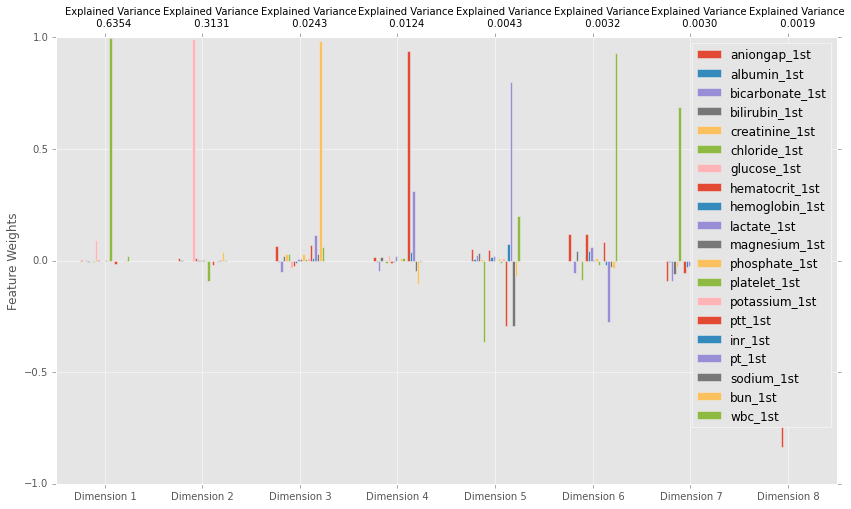

In [54]:

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 8).fit(data2[data2.columns[1:]])
# is this redundant?
#pca.fit(just_measures)
# TODO: Transform log_samples using the PCA fit above

# Generate PCA results plot
pca_results = vs.pca_results(data2, pca)

In [58]:
data2.shape

(688, 20)

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


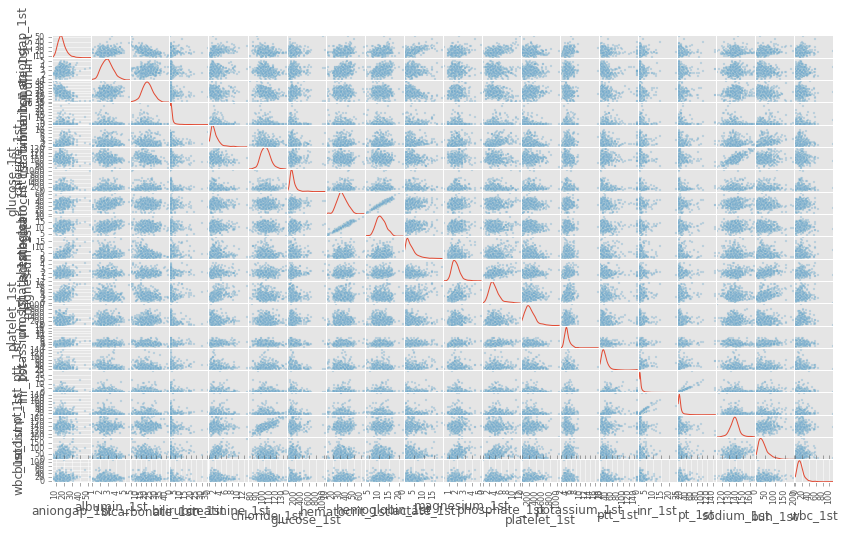

In [71]:
pd.scatter_matrix(data2, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

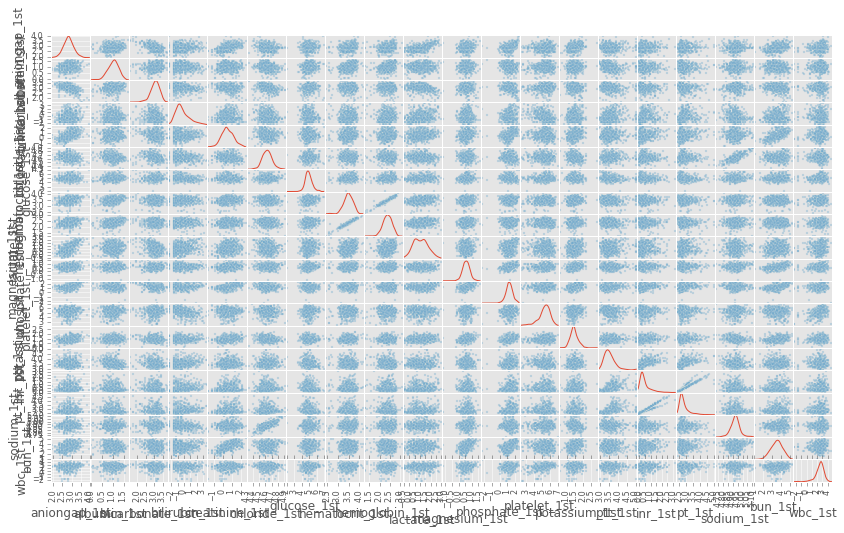

In [73]:
log_data = np.log(data2)
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


In [98]:
names_dict = {}
suffix = '_outliers'


for feature in data2.keys():
    if feature != 'mort_hosp':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(data2[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(data2[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        print "Data points considered outliers for the feature '{}':".format(feature)
        display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

Data points considered outliers for the feature 'aniongap_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
25           0          31.0          2.1             16.0            0.3   
34           0          35.0          4.1             16.0            0.8   
101          0          32.0          1.8             15.0            1.5   
123          0          32.0          2.2             10.0            2.6   
158          1          33.0          2.3             20.0            0.3   
205          0          53.0          3.4              6.0            0.1   
327          1          32.0          3.3             10.0            0.9   
350          0          32.0          3.8             15.0            0.5   
356          0          37.0          4.6             16.0            0.7   
381          0          36.0          2.0              5.0            0.5   
389          0          37.0          5.6             13.0            1.1   
407          1          40.0          2.8              6.0            3.2   
447          1          31.0          2.8             21.0            5.3   
475          1          32.0          2.5             10.0            7.1   
533          1          34.0          3.0              5.0            0.4   
547          1          46.0          3.2              7.0           11.4   
564          0          32.0          3.3              6.0            0.2   
573          1          32.0          2.9             21.0            3.9   
609          1          33.0          3.7             15.0            8.0   
631          1          31.0          1.7              7.0           16.0   
638          1          30.0          2.6              9.0            0.3   
675          0          32.0          2.3             18.0            2.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
25              1.1          97.0        163.0            40.8   
34              7.9         114.0        142.0            45.6   
101             5.2          91.0         83.0            37.8   
123             2.4         105.0        112.0            33.2   
158             3.9          94.0        136.0            29.4   
205             1.5          89.0        989.0            41.8   
327             2.1         106.0        110.0            38.5   
350             2.6         100.0        483.0            37.8   
356             1.2         101.0        222.0            46.3   
381             3.0          95.0         86.0            42.6   
389             4.0          93.0        159.0            39.3   
407             6.2          83.0         66.0            44.4   
447             2.2          90.0         44.0            44.9   
475             3.5          82.0        154.0            43.2   
533             8.5          99.0        266.0            30.5   
547             2.5          91.0         62.0            50.6   
564            12.9         106.0        127.0            31.9   
573             1.4          87.0        146.0            22.0   
609             4.8          97.0         98.0            44.5   
631             4.5         101.0         97.0            14.8   
638             6.2         116.0         79.0            26.0   
675             1.9          83.0        349.0            20.9   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
25             12.5   ...               1.7            4.9         407.0   
34             15.2   ...               3.3            5.2         187.0   
101            12.6   ...               1.2            7.6         261.0   
123            10.6   ...               1.2            6.8         333.0   
158            10.1   ...               5.1            7.0         429.0   
205            12.5   ...               2.3           12.0         343.0   
327            12.4   ...               3.8            5.7         136.0   
350            12.9   ...               1.9            3.7         363.0   
356            16.7   ...     

Data points considered outliers for the feature 'albumin_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
126          1          18.0          1.0             15.0            0.5   
249          0          22.0          4.8             15.0            0.3   
304          0          24.0          4.7             31.0            0.5   
325          0          20.0          4.9             29.0            0.3   
389          0          37.0          5.6             13.0            1.1   
394          0          21.0          4.7             23.0            0.5   
636          0          16.0          4.7             22.0            1.2   
665          0          17.0          4.9             24.0            1.0   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
126             1.3         109.0         94.0            23.3   
249             1.4         103.0        203.0            34.0   
304             7.5          92.0        183.0            39.1   
325             1.3         100.0        191.0            40.0   
389             4.0          93.0        159.0            39.3   
394             1.5         100.0        234.0            43.9   
636             1.5         104.0        100.0            45.9   
665             1.0          96.0        111.0            40.4   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
126             9.5   ...               1.4            4.3          78.0   
249            11.6   ...               2.0            3.4         364.0   
304            12.2   ...               2.2            3.1         199.0   
325            13.1   ...               1.5            2.4         249.0   
389            13.8   ...               1.5            9.8         267.0   
394            15.9   ...               2.4            5.4         317.0   
636            15.5   ...               1.3            0.2         155.0   
665            15.3   ...               1.8            2.6         135.0   

     potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
126            2.8     50.0      1.7    18.4       139.0     49.0      9.7  
249            5.6     23.6      1.2    14.1       134.0     28.0     17.4  
304            6.9     28.6      1.2    13.7       140.0     43.0     10.0  
325            4.0     24.3      1.3    14.4       145.0     32.0     13.1  
389            4.6     23.6      1.2    14.0       138.0     38.0     22.4  
394            4.7     43.1      1.8    19.6       139.0     25.0     15.6  
636            4.3     32.3      1.4    14.7       138.0     21.0      1.6  
665            3.3     31.9      1.2    12.5       134.0     23.0     15.5  

[8 rows x 21 columns]

Data points considered outliers for the feature 'bicarbonate_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
205          0          53.0          3.4              6.0            0.1   
340          0          23.0          3.4              7.0            0.3   
351          0          11.0          2.5             43.0            0.2   
381          0          36.0          2.0              5.0            0.5   
392          0           7.0          2.1             41.0            0.9   
407          1          40.0          2.8              6.0            3.2   
465          0          10.0          3.8             42.0            1.1   
533          1          34.0          3.0              5.0            0.4   
536          1          12.0          3.7             39.0            1.1   
547          1          46.0          3.2              7.0           11.4   
564          0          32.0          3.3              6.0            0.2   
568          1          29.0          2.0              7.0            0.4   
631          1          31.0          1.7              7.0           16.0   
664          1          16.0          2.6             38.0            0.3   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
205             1.5          89.0        989.0            41.8   
340             8.3          85.0       1034.0            43.2   
351             2.3          89.0        125.0            31.2   
381             3.0          95.0         86.0            42.6   
392             1.0          95.0        113.0            22.8   
407             6.2          83.0         66.0            44.4   
465             1.0          77.0        466.0            25.5   
533             8.5          99.0        266.0            30.5   
536             2.3          97.0        135.0            38.0   
547             2.5          91.0         62.0            50.6   
564            12.9         106.0        127.0            31.9   
568             5.2         105.0        374.0            37.0   
631             4.5         101.0         97.0            14.8   
664             4.3         106.0        292.0            28.4   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
205            12.5   ...               2.3           12.0         343.0   
340            13.5   ...               3.9            9.2         241.0   
351            10.1   ...               2.6            3.3         369.0   
381            15.2   ...               3.0           10.5         298.0   
392             7.3   ...               2.3            3.5         209.0   
407            14.4   ...               2.1           10.7         261.0   
465             8.5   ...               1.6            2.6         175.0   
533             9.4   ...               1.9            9.1         164.0   
536            12.1   ...               3.2            3.1         331.0   
547            15.4   ...               4.3           10.7          81.0   
564            10.4   ...               2.2            9.3         398.0   
568            12.8   ...               1.8            7.4          70.0   
631             4.1   ...               3.7            7.9         177.0   
664             8.9   ...               3.0            1.5         104.0   

     potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
205            6.1     23.3      1.3    13.9       142.0     23.0    21.80  
340            4.5     19.7      1.1    13.1       123.0    113.0    13.21  
351            3.0     27.0      1.2    13.6       140.0     70.0    43.40  
381            4.6     34.4      1.8    19.7       129.0     95.0    28.00  
392            4.0     51.3      2.4    23.7       139.0     50.0    12.80  
407            5.7    150.0     14.1   104.8       123.0     77.0    20.60  
465            2.1     27.5      1.6    17.4       125.0     17.0    17.90  
533            7.1     64.4      2.0    20.9       131.0     66.0    12.40  
536            3.8     3

Data points considered outliers for the feature 'bilirubin_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
8            0          20.0          3.1             16.0            5.8   
14           1          17.0          3.6             25.0           10.3   
18           1          16.0          2.9             21.0            6.7   
19           1          12.0          2.3             23.0           10.6   
20           0          18.0          2.1             20.0            3.4   
22           0          18.0          3.2             19.0            3.1   
27           1          16.0          2.0             16.0            5.6   
28           0          16.0          2.3             12.0            3.3   
60           1          24.0          2.3             20.0            4.9   
68           1          27.0          3.6             14.0           35.7   
71           0          23.0          2.0             12.0            2.8   
76           0          15.0          2.6             17.0            6.0   
80           1          17.0          2.0             18.0           19.9   
86           0          21.0          2.4             17.0            5.8   
92           1          22.0          2.7             14.0           18.5   
111          0          15.0          2.1             25.0            6.1   
113          0          13.0          3.0             18.0            4.2   
116          1          20.0          3.6             23.0            6.9   
118          1          26.0          1.9             15.0            5.3   
119          0          19.0          3.1             23.0            2.8   
125          1          19.0          2.1             19.0            7.5   
138          1          19.0          2.1             14.0           14.7   
155          1          17.0          2.4             19.0            2.8   
167          1          19.0          3.0             22.0            3.2   
171          1          15.0          1.5             18.0           17.9   
192          0          16.0          1.8             16.0           17.5   
194          0          19.0          2.1             15.0           23.2   
197          0          25.0          2.8             11.0            3.6   
201          1          21.0          2.6             25.0            4.8   
206          1          27.0          1.8             15.0           11.0   
..         ...           ...          ...              ...            ...   
508          0          20.0          2.2             15.0            7.3   
527          0          14.0          2.2             21.0            4.4   
535          0          16.0          2.1             23.0            3.4   
541          0          16.0          2.4             17.0            3.2   
544          0          13.0          2.7             21.0           19.4   
547          1          46.0          3.2              7.0           11.4   
555          0          25.0          2.5             15.0            3.7   
570          0          13.0          3.1             19.0           10.2   
573          1          32.0          2.9             21.0            3.9   
581          0          19.0          2.6             19.0            5.0   
583          0          14.0          2.4             33.0            6.3   
587          0          14.0          2.7             20.0            2.9   
590          1          24.0          2.5             15.0            3.4   
597          0          23.0          3.9             16.0            9.9   
609          1          33.0          3.7             15.0            8.0   
618          1          12.0          2.7             25.0            3.0   
624          0          16.0          2.5             19.0            3.8   
625          0          17.0          2.2             22.0           11.2   
626          0          15.0          3.4             19.0            3.5   
627          1          19.0          2.4             15.0            6.3   
6

Data points considered outliers for the feature 'creatinine_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
2            0          22.0          2.6             30.0            0.3   
32           1          24.0          2.3             15.0            1.8   
33           1          28.0          3.7             21.0            2.6   
34           0          35.0          4.1             16.0            0.8   
41           0          18.0          1.9             21.0            0.7   
44           0          26.0          3.4              9.0            0.1   
58           0          28.0          2.3             19.0            0.5   
59           1          24.0          2.3             13.0            0.2   
62           0          20.0          3.0             24.0            0.4   
63           0          20.0          2.8             20.0            1.2   
64           0          17.0          2.9             25.0            1.0   
68           1          27.0          3.6             14.0           35.7   
84           0          17.0          2.6             29.0            0.2   
87           0          20.0          2.8             22.0            0.3   
95           1          22.0          1.7             18.0            1.1   
101          0          32.0          1.8             15.0            1.5   
108          1          27.0          2.9             19.0            0.6   
118          1          26.0          1.9             15.0            5.3   
134          0          22.0          2.8             19.0            0.2   
182          0          22.0          2.8             25.0            0.5   
195          1          18.0          2.1             24.0            0.2   
220          0          24.0          3.4             22.0            1.1   
251          1          21.0          3.5             28.0            1.7   
283          0          17.0          2.5             26.0            0.2   
304          0          24.0          4.7             31.0            0.5   
305          0          27.0          2.6             23.0            0.2   
340          0          23.0          3.4              7.0            0.3   
355          0          21.0          3.2             25.0            0.7   
407          1          40.0          2.8              6.0            3.2   
451          0          19.0          2.8             19.0            0.5   
453          0          17.0          3.1             32.0            0.4   
486          0          19.0          1.7             19.0            0.5   
491          0          16.0          4.6             34.0            0.5   
533          1          34.0          3.0              5.0            0.4   
545          0          20.0          3.3             22.0            0.6   
564          0          32.0          3.3              6.0            0.2   
568          1          29.0          2.0              7.0            0.4   
574          1          25.0          2.6             23.0            0.5   
614          0          22.0          3.4             25.0            0.1   
628          0          21.0          3.9             32.0            3.7   
635          0          28.0          1.3             14.0            0.6   
638          1          30.0          2.6              9.0            0.3   
646          0          17.0          2.2             20.0            0.4   
657          0          21.0          2.7             20.0            0.1   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
2               7.6          91.0        128.0            33.3   
32              6.9         100.0        118.0            39.1   
33              8.8          93.0         61.0            40.5   
34              7.9         114.0        142.0            45.6   
41              5.8         126.0        119.0            27.4   
44              5.9         115.0        221.0            37.4   
58              7.0          95.0        165.0            29.5   
59         

Data points considered outliers for the feature 'chloride_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
3            0          17.0          2.9             20.0            0.2   
41           0          18.0          1.9             21.0            0.7   
50           0          16.0          2.3             16.0            0.6   
109          0          28.0          4.4             25.0            1.8   
160          1          19.0          3.6             16.0            0.7   
232          0          16.0          2.5             26.0            0.6   
265          0          19.0          2.3             16.0            0.5   
311          0          16.0          2.5             22.0            0.4   
395          1          19.0          2.1             18.0            0.4   
425          0          16.0          2.7             28.0            0.4   
463          0          16.0          2.6             17.0            0.4   
465          0          10.0          3.8             42.0            1.1   
500          1          24.0          1.9             19.0            0.3   
516          1          21.0          2.7             18.0            0.3   
584          0          22.0          3.0             16.0            0.2   
681          0          16.0          2.1             16.0            0.6   
683          0          17.0          2.6             13.0            0.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
3               1.9         132.0        231.0            31.5   
41              5.8         126.0        119.0            27.4   
50              3.3         130.0        254.0            31.9   
109             3.6          75.0        258.0            31.0   
160             1.2         135.0        347.0            46.0   
232             2.3         125.0        148.0            20.0   
265             3.5         123.0        614.0            30.7   
311             2.8         129.0        170.0            22.8   
395             3.6         130.0        327.0            31.8   
425             1.1         124.0        239.0            43.0   
463             2.3         130.0        170.0            29.4   
465             1.0          77.0        466.0            25.5   
500             2.6         124.0        185.0            35.7   
516             0.9          81.0         89.0            24.3   
584             3.0         127.0        149.0            31.3   
681             1.1         135.0        133.0            13.3   
683             1.6         124.0        561.0            37.9   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
3              10.1   ...               2.3            2.6         109.0   
41              8.7   ...               1.6            4.4         104.0   
50              9.7   ...               3.2            2.2         115.0   
109            10.5   ...               2.1            5.2         345.0   
160            15.0   ...               3.5            3.0         261.0   
232             6.7   ...               1.4            3.5         434.0   
265             9.4   ...               2.3            6.1         221.0   
311             7.3   ...               2.3            2.0         114.0   
395            10.0   ...               2.3            3.7         217.0   
425            13.2   ...               2.6            3.1         266.0   
463             9.6   ...               2.4            2.1         279.0   
465             8.5   ...               1.6            2.6         175.0   
500            11.0   ...               2.6            5.4         186.0   
516             7.7   ...               2.6            2.3        1053.0   
584             9.0   ...               2.9            5.9         161.0   
681             3.6   ...               2.6            5.5          17.0   
683            12.6   ...               1.9            3.5         516.0   

     potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  bu

Data points considered outliers for the feature 'glucose_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
39           1          21.0          2.7             18.0            0.5   
51           0          20.0          2.2             26.0            0.5   
64           0          17.0          2.9             25.0            1.0   
70           0          17.0          4.1             24.0            0.6   
82           0          24.0          2.9             20.0            1.0   
85           0          19.0          3.3             19.0            0.8   
91           0          21.0          2.9             26.0            0.2   
99           0          18.0          3.1             26.0            0.7   
103          0          15.0          2.7             28.0            0.4   
145          0          20.0          2.8             22.0            0.5   
148          0          23.0          2.5             21.0            0.7   
160          1          19.0          3.6             16.0            0.7   
165          1          17.0          3.0             27.0            0.3   
205          0          53.0          3.4              6.0            0.1   
211          0          19.0          2.7             18.0            0.8   
219          1          18.0          1.7             17.0            9.0   
238          0          22.0          3.0             20.0            0.2   
265          0          19.0          2.3             16.0            0.5   
282          0          21.0          3.0             26.0            0.2   
285          1          10.0          2.3             27.0            1.5   
290          0          24.0          3.1             21.0            0.6   
293          0          18.0          3.4             24.0            0.4   
308          0          16.0          1.9             22.0            0.4   
330          0          10.0          2.8             27.0            0.4   
340          0          23.0          3.4              7.0            0.3   
348          1          12.0          2.7             28.0            1.7   
350          0          32.0          3.8             15.0            0.5   
395          1          19.0          2.1             18.0            0.4   
429          1          12.0          2.3             27.0            0.5   
465          0          10.0          3.8             42.0            1.1   
484          0          22.0          3.7             24.0            0.5   
548          0          22.0          3.7             26.0            0.4   
556          0          14.0          2.3              9.0            0.2   
559          0          28.0          4.4             19.0            0.5   
566          0          17.0          2.2             18.0            1.4   
568          1          29.0          2.0              7.0            0.4   
575          1          24.0          1.7             20.0            0.8   
576          1          14.0          2.6             30.0            0.6   
594          0          29.0          3.8             11.0            0.3   
620          0          21.0          4.1             25.0            0.6   
630          1          17.0          2.8             35.0            0.4   
671          0          16.0          2.9             22.0            0.6   
675          0          32.0          2.3             18.0            2.6   
678          0          17.0          2.4             24.0            0.3   
683          0          17.0          2.6             13.0            0.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
39              2.0         110.0        469.0            36.7   
51              1.6         101.0        362.0            40.3   
64              6.4          92.0        419.0            42.8   
70              0.9          95.0        298.0            37.2   
82              1.9          94.0        470.0            42.8   
85              1.8         102.0        388.0            29.7   


Data points considered outliers for the feature 'hematocrit_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
6            0          19.0          3.7             23.0            0.8   
194          0          19.0          2.1             15.0           23.2   
318          0          11.0          2.0             25.0            0.4   
348          1          12.0          2.7             28.0            1.7   
359          0          28.0          4.4             15.0            0.3   
498          0          17.0          3.0             19.0            4.9   
499          1          19.0          2.6             21.0            7.9   
546          1          17.0          3.8             27.0            2.1   
558          0          10.0          3.4              8.0            0.6   
631          1          31.0          1.7              7.0           16.0   
639          1          28.0          3.0             22.0           17.8   
672          1          10.0          2.1             10.0            1.0   
681          0          16.0          2.1             16.0            0.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
6               1.5          92.0         77.0            13.3   
194             2.0          96.0        213.0            13.5   
318             0.8         106.0         92.0            14.1   
348             0.7         104.0        450.0            13.0   
359             1.9         106.0        109.0            52.1   
498             0.7         106.0         42.0            11.3   
499             1.4         107.0        224.0            52.4   
546             1.5          95.0         88.0            62.7   
558             3.1         111.0        130.0            57.8   
631             4.5         101.0         97.0            14.8   
639             1.4          87.0        209.0            64.1   
672             0.6         122.0         47.0            15.1   
681             1.1         135.0        133.0            13.3   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
6               4.8   ...               1.5            2.1         304.0   
194             4.7   ...               1.5            4.0          15.0   
318             9.6   ...               1.6            3.2         195.0   
348             4.1   ...               1.7            2.1          52.0   
359            16.3   ...               2.0            4.4         365.0   
498             3.6   ...               1.5            1.4          51.0   
499            16.2   ...               2.6            4.9          55.0   
546            19.8   ...               2.3            8.7         197.0   
558            17.7   ...               1.9            4.9         153.0   
631             4.1   ...               3.7            7.9         177.0   
639            21.7   ...               2.1            5.6          48.0   
672             4.8   ...               0.8            1.0          75.0   
681             3.6   ...               2.6            5.5          17.0   

     potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
6              3.6     29.1      1.1    13.1       130.0     27.0     18.2  
194            4.5     64.6      3.3    22.3       125.0     67.0      1.1  
318            4.1     36.8      1.2    13.6       138.0     11.0     11.4  
348            4.2     30.4      2.7    20.6       132.0     17.0     54.8  
359            5.5     34.8      1.3    14.1       143.0     42.0     14.3  
498            5.0     61.4      2.2    23.4       137.0     14.0      3.3  
499            4.5     30.8      1.8    19.8       142.0     67.0     14.8  
546            4.9     32.0      1.6    17.5       143.0     33.0     17.7  
558            6.7     38.1      1.6    18.0       122.0     53.0     23.5  
631            7.1     79.3      5.4    53.9       131.0    157.0     33.2  
639            7.6     40.6      2.1    22.8       129.0     55.0      8.9  
672         

Data points considered outliers for the feature 'hemoglobin_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
348          1          12.0          2.7             28.0            1.7   
498          0          17.0          3.0             19.0            4.9   
546          1          17.0          3.8             27.0            2.1   
558          0          10.0          3.4              8.0            0.6   
631          1          31.0          1.7              7.0           16.0   
639          1          28.0          3.0             22.0           17.8   
681          0          16.0          2.1             16.0            0.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
348             0.7         104.0        450.0            13.0   
498             0.7         106.0         42.0            11.3   
546             1.5          95.0         88.0            62.7   
558             3.1         111.0        130.0            57.8   
631             4.5         101.0         97.0            14.8   
639             1.4          87.0        209.0            64.1   
681             1.1         135.0        133.0            13.3   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
348             4.1   ...               1.7            2.1          52.0   
498             3.6   ...               1.5            1.4          51.0   
546            19.8   ...               2.3            8.7         197.0   
558            17.7   ...               1.9            4.9         153.0   
631             4.1   ...               3.7            7.9         177.0   
639            21.7   ...               2.1            5.6          48.0   
681             3.6   ...               2.6            5.5          17.0   

     potassium_1st  ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
348            4.2     30.4      2.7    20.6       132.0     17.0     54.8  
498            5.0     61.4      2.2    23.4       137.0     14.0      3.3  
546            4.9     32.0      1.6    17.5       143.0     33.0     17.7  
558            6.7     38.1      1.6    18.0       122.0     53.0     23.5  
631            7.1     79.3      5.4    53.9       131.0    157.0     33.2  
639            7.6     40.6      2.1    22.8       129.0     55.0      8.9  
681            4.3     53.3      2.3    24.3       163.0     62.0      4.6  

[7 rows x 21 columns]

Data points considered outliers for the feature 'lactate_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
11           0          26.0          2.3             11.0            0.6   
25           0          31.0          2.1             16.0            0.3   
47           1          24.0          3.3             18.0            0.4   
49           1          24.0          1.1              9.0            1.8   
60           1          24.0          2.3             20.0            4.9   
71           0          23.0          2.0             12.0            2.8   
92           1          22.0          2.7             14.0           18.5   
96           0          29.0          2.7             13.0            0.4   
108          1          27.0          2.9             19.0            0.6   
118          1          26.0          1.9             15.0            5.3   
121          0          20.0          2.6             17.0            0.6   
123          0          32.0          2.2             10.0            2.6   
155          1          17.0          2.4             19.0            2.8   
168          1          23.0          2.0             14.0            0.3   
206          1          27.0          1.8             15.0           11.0   
215          1          26.0          3.0             12.0           10.1   
217          0          27.0          3.1             20.0            0.6   
274          0          15.0          3.8             18.0            0.2   
292          1          25.0          3.0             19.0            1.8   
327          1          32.0          3.3             10.0            0.9   
342          0          25.0          3.6             16.0            1.9   
350          0          32.0          3.8             15.0            0.5   
356          0          37.0          4.6             16.0            0.7   
358          0          26.0          2.7             16.0            3.7   
368          0          25.0          2.6             12.0            0.9   
372          0          25.0          3.7             18.0            5.0   
407          1          40.0          2.8              6.0            3.2   
447          1          31.0          2.8             21.0            5.3   
475          1          32.0          2.5             10.0            7.1   
508          0          20.0          2.2             15.0            7.3   
510          0          12.0          2.9             20.0            0.4   
533          1          34.0          3.0              5.0            0.4   
547          1          46.0          3.2              7.0           11.4   
549          1          22.0          3.8             12.0            0.4   
555          0          25.0          2.5             15.0            3.7   
573          1          32.0          2.9             21.0            3.9   
590          1          24.0          2.5             15.0            3.4   
594          0          29.0          3.8             11.0            0.3   
609          1          33.0          3.7             15.0            8.0   
621          1          27.0          2.8             14.0            0.6   
631          1          31.0          1.7              7.0           16.0   
675          0          32.0          2.3             18.0            2.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
11              3.1         108.0         86.0            44.4   
25              1.1          97.0        163.0            40.8   
47              3.8         105.0        104.0            39.8   
49              3.1          96.0         58.0            33.3   
60              1.5         100.0        180.0            26.9   
71              0.8         109.0         62.0            28.1   
92              4.2          85.0         73.0            39.4   
96              1.8         107.0        190.0            39.5   
108             5.8          92.0        165.0            33.0   
118             5.4          86.0

Data points considered outliers for the feature 'magnesium_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
34           0          35.0          4.1             16.0            0.8   
50           0          16.0          2.3             16.0            0.6   
89           0          19.0          3.1             31.0            0.4   
91           0          21.0          2.9             26.0            0.2   
158          1          33.0          2.3             20.0            0.3   
160          1          19.0          3.6             16.0            0.7   
168          1          23.0          2.0             14.0            0.3   
182          0          22.0          2.8             25.0            0.5   
190          0          13.0          2.0             30.0            0.4   
196          0          28.0          4.0             15.0            0.4   
238          0          22.0          3.0             20.0            0.2   
327          1          32.0          3.3             10.0            0.9   
340          0          23.0          3.4              7.0            0.3   
412          0          15.0          1.8             29.0            0.3   
421          1          27.0          2.3              9.0            0.5   
536          1          12.0          3.7             39.0            1.1   
547          1          46.0          3.2              7.0           11.4   
549          1          22.0          3.8             12.0            0.4   
619          1          16.0          2.3             19.0            0.9   
631          1          31.0          1.7              7.0           16.0   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
34              7.9         114.0        142.0            45.6   
50              3.3         130.0        254.0            31.9   
89              3.6          87.0        146.0            30.3   
91              2.0         103.0        558.0            49.1   
158             3.9          94.0        136.0            29.4   
160             1.2         135.0        347.0            46.0   
168             1.4         104.0        143.0            37.0   
182             5.6         108.0        117.0            35.4   
190             1.7         111.0        180.0            23.6   
196             4.2         104.0        110.0            40.2   
238             2.1          99.0        348.0            27.4   
327             2.1         106.0        110.0            38.5   
340             8.3          85.0       1034.0            43.2   
412             3.0          93.0        142.0            34.2   
421             4.2         111.0         77.0            26.6   
536             2.3          97.0        135.0            38.0   
547             2.5          91.0         62.0            50.6   
549             2.6         104.0        165.0            32.0   
619             1.6         111.0        206.0            27.3   
631             4.5         101.0         97.0            14.8   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
34             15.2   ...               3.3            5.2         187.0   
50              9.7   ...               3.2            2.2         115.0   
89             10.5   ...               3.7            6.7         352.0   
91             15.8   ...               3.1            4.1         346.0   
158            10.1   ...               5.1            7.0         429.0   
160            15.0   ...               3.5            3.0         261.0   
168            12.2   ...               4.3            4.8         378.0   
182            11.8   ...               3.6            4.0         180.0   
190             7.4   ...               3.1            4.0         357.0   
196            14.1   ...               0.3            3.6         267.0   
238             8.6   ...               3.5            5.0         307.0   
327            12.4   ...               3.8            5.7         136.0   
340         

Data points considered outliers for the feature 'phosphate_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
32           1          24.0          2.3             15.0            1.8   
49           1          24.0          1.1              9.0            1.8   
59           1          24.0          2.3             13.0            0.2   
65           0          24.0          3.5             12.0            0.3   
92           1          22.0          2.7             14.0           18.5   
101          0          32.0          1.8             15.0            1.5   
106          0          18.0          3.3             30.0            0.3   
118          1          26.0          1.9             15.0            5.3   
205          0          53.0          3.4              6.0            0.1   
206          1          27.0          1.8             15.0           11.0   
212          1          26.0          2.3             14.0            1.6   
230          0          21.0          1.6             12.0            1.5   
236          0          22.0          3.3             17.0            0.3   
300          0          18.0          3.0             25.0            0.1   
310          0          25.0          2.6             19.0           11.9   
340          0          23.0          3.4              7.0            0.3   
362          0          22.0          3.2             15.0            1.1   
365          1          22.0          2.4             17.0            1.6   
381          0          36.0          2.0              5.0            0.5   
389          0          37.0          5.6             13.0            1.1   
407          1          40.0          2.8              6.0            3.2   
412          0          15.0          1.8             29.0            0.3   
421          1          27.0          2.3              9.0            0.5   
447          1          31.0          2.8             21.0            5.3   
466          1          25.0          3.1             23.0            4.0   
475          1          32.0          2.5             10.0            7.1   
508          0          20.0          2.2             15.0            7.3   
533          1          34.0          3.0              5.0            0.4   
546          1          17.0          3.8             27.0            2.1   
547          1          46.0          3.2              7.0           11.4   
549          1          22.0          3.8             12.0            0.4   
564          0          32.0          3.3              6.0            0.2   
568          1          29.0          2.0              7.0            0.4   
581          0          19.0          2.6             19.0            5.0   
609          1          33.0          3.7             15.0            8.0   
621          1          27.0          2.8             14.0            0.6   
631          1          31.0          1.7              7.0           16.0   
638          1          30.0          2.6              9.0            0.3   
657          0          21.0          2.7             20.0            0.1   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
32              6.9         100.0        118.0            39.1   
49              3.1          96.0         58.0            33.3   
59              6.1         108.0        142.0            33.2   
65              4.7         113.0        198.0            36.0   
92              4.2          85.0         73.0            39.4   
101             5.2          91.0         83.0            37.8   
106             3.1          90.0        192.0            37.0   
118             5.4          86.0         92.0            27.8   
205             1.5          89.0        989.0            41.8   
206             3.5          96.0         35.0            38.8   
212             2.3         104.0        270.0            39.0   
230             3.2         118.0         90.0            36.6   
236             3.7         105.0         51.0            26.1   


Data points considered outliers for the feature 'platelet_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
23           0          19.0          2.4             22.0            0.4   
55           0          14.0          2.8             31.0            0.7   
88           1          11.0          1.8             29.0            0.1   
112          0          19.0          4.3             22.0            0.6   
128          0          16.0          3.3             22.0            0.2   
132          1          13.0          1.7             21.0            0.4   
259          0          15.0          2.7             20.0            0.4   
268          0          14.0          1.6             17.0            0.2   
273          0          14.0          4.3             34.0            0.5   
317          0          11.0          2.6             22.0            0.4   
357          0          21.0          2.6             22.0            0.2   
432          0          24.0          3.9             24.0            0.6   
436          0          23.0          2.1             15.0            0.2   
512          0          11.0          2.8             25.0            0.2   
516          1          21.0          2.7             18.0            0.3   
569          0          23.0          3.7             22.0            1.2   
592          1          23.0          2.5             24.0            0.3   
657          0          21.0          2.7             20.0            0.1   
660          0          11.0          2.4             21.0            0.2   
667          0          21.0          2.9             16.0            0.4   
686          0          12.0          2.1             19.0            0.5   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
23              0.9         105.0        192.0            40.3   
55              0.3          95.0        100.0            29.0   
88              1.1         105.0         83.0            22.8   
112             1.1         101.0         97.0            34.8   
128             1.9         104.0        115.0            28.1   
132             0.9         108.0         83.0            23.5   
259             1.7         121.0        143.0            27.2   
268             0.9         115.0        125.0            32.2   
273             1.3          96.0        152.0            31.7   
317             1.2          98.0        156.0            32.6   
357             0.6         102.0        160.0            29.5   
432             4.2         114.0        237.0            42.4   
436             4.4          97.0        245.0            35.7   
512             1.2         105.0         95.0            23.2   
516             0.9          81.0         89.0            24.3   
569             1.3          92.0        118.0            35.9   
592             2.9          91.0         98.0            42.5   
657             5.7         102.0         72.0            35.5   
660             0.3         108.0        107.0            25.4   
667             1.5         108.0        159.0            32.4   
686             1.2         108.0        193.0            33.9   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
23             13.3   ...               1.5            2.8         604.0   
55              9.7   ...               1.7            3.2         744.0   
88              7.4   ...               1.4            3.5         689.0   
112            10.1   ...               1.7            3.3         608.0   
128             8.6   ...               1.7            5.0         683.0   
132             7.4   ...               1.7            3.5         622.0   
259             8.8   ...               2.8            4.1         762.0   
268            10.7   ...               1.6            4.3         615.0   
273             9.2   ...               2.2            3.1         592.0   
317            10.7   ...               1.8            2.0         710.0   
357             9.1  

Data points considered outliers for the feature 'potassium_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
20           0          18.0          2.1             20.0            3.4   
25           0          31.0          2.1             16.0            0.3   
33           1          28.0          3.7             21.0            2.6   
34           0          35.0          4.1             16.0            0.8   
89           0          19.0          3.1             31.0            0.4   
92           1          22.0          2.7             14.0           18.5   
108          1          27.0          2.9             19.0            0.6   
145          0          20.0          2.8             22.0            0.5   
162          0          19.0          2.9             21.0            0.4   
206          1          27.0          1.8             15.0           11.0   
220          0          24.0          3.4             22.0            1.1   
266          0          18.0          2.9             30.0            0.3   
298          1          21.0          2.3             22.0            2.4   
304          0          24.0          4.7             31.0            0.5   
324          1          19.0          3.0             15.0            8.0   
334          0          23.0          3.0             20.0            0.4   
341          0          15.0          2.7             19.0            2.3   
370          0          18.0          3.0             29.0            0.7   
416          0          18.0          2.5             25.0            0.5   
484          0          22.0          3.7             24.0            0.5   
492          0          15.0          1.6             15.0            0.3   
533          1          34.0          3.0              5.0            0.4   
539          0          21.0          2.7             20.0            0.6   
547          1          46.0          3.2              7.0           11.4   
574          1          25.0          2.6             23.0            0.5   
589          0          20.0          2.8             25.0            0.4   
631          1          31.0          1.7              7.0           16.0   
639          1          28.0          3.0             22.0           17.8   
672          1          10.0          2.1             10.0            1.0   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
20              1.6          95.0        105.0            33.4   
25              1.1          97.0        163.0            40.8   
33              8.8          93.0         61.0            40.5   
34              7.9         114.0        142.0            45.6   
89              3.6          87.0        146.0            30.3   
92              4.2          85.0         73.0            39.4   
108             5.8          92.0        165.0            33.0   
145             4.2          92.0        317.0            32.9   
162             3.9         103.0        101.0            33.3   
206             3.5          96.0         35.0            38.8   
220             8.4          94.0        119.0            34.2   
266             2.6          96.0         91.0            43.7   
298             4.8          94.0         60.0            29.2   
304             7.5          92.0        183.0            39.1   
324             2.8         107.0         79.0            27.1   
334             2.3         101.0        111.0            35.3   
341             1.1         101.0        136.0            38.7   
370             1.2         100.0        114.0            31.2   
416             1.3          95.0        112.0            32.0   
484             2.6         104.0        343.0            36.7   
492             0.4         106.0        153.0            29.0   
533             8.5          99.0        266.0            30.5   
539             1.0         104.0        237.0            33.0   
547             2.5          91.0         62.0            50.6   
574             5.5          94.0        128

Data points considered outliers for the feature 'ptt_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
11           0          26.0          2.3             11.0            0.6   
13           0          17.0          2.1             23.0            1.2   
28           0          16.0          2.3             12.0            3.3   
38           0          19.0          2.4             27.0            1.6   
49           1          24.0          1.1              9.0            1.8   
60           1          24.0          2.3             20.0            4.9   
62           0          20.0          3.0             24.0            0.4   
63           0          20.0          2.8             20.0            1.2   
73           0          19.0          3.7             19.0            0.9   
111          0          15.0          2.1             25.0            6.1   
117          0          14.0          3.2             21.0            2.4   
118          1          26.0          1.9             15.0            5.3   
129          0          14.0          2.8             25.0            0.2   
130          0          18.0          2.5             20.0            0.3   
155          1          17.0          2.4             19.0            2.8   
177          1          14.0          1.9             17.0            0.8   
183          0          24.0          2.5             11.0            0.2   
194          0          19.0          2.1             15.0           23.2   
208          1          17.0          3.6             23.0            0.4   
214          1           7.0          2.5             24.0            1.4   
215          1          26.0          3.0             12.0           10.1   
225          1          27.0          2.8             13.0            0.9   
261          0          18.0          3.1             34.0            0.6   
266          0          18.0          2.9             30.0            0.3   
306          1          13.0          1.8             16.0            1.3   
307          0          18.0          2.2             29.0            1.9   
331          0           9.0          2.0             22.0            0.3   
336          0          25.0          2.1             17.0            1.1   
365          1          22.0          2.4             17.0            1.6   
373          0          13.0          3.7             28.0            0.3   
383          0          18.0          2.0             25.0            0.4   
387          1          22.0          2.6             26.0            0.2   
407          1          40.0          2.8              6.0            3.2   
472          1          22.0          3.2             17.0            2.4   
475          1          32.0          2.5             10.0            7.1   
492          0          15.0          1.6             15.0            0.3   
498          0          17.0          3.0             19.0            4.9   
533          1          34.0          3.0              5.0            0.4   
550          1          16.0          2.9             15.0            0.5   
568          1          29.0          2.0              7.0            0.4   
609          1          33.0          3.7             15.0            8.0   
626          0          15.0          3.4             19.0            3.5   
629          0          13.0          3.4             21.0            0.4   
631          1          31.0          1.7              7.0           16.0   
632          0          18.0          3.2             18.0            3.1   
672          1          10.0          2.1             10.0            1.0   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
11              3.1         108.0         86.0            44.4   
13              1.5          94.0         74.0            34.7   
28              1.9         117.0        105.0            33.6   
38              3.8          90.0        109.0            20.6   
49              3.1          96.0         58.0         

Data points considered outliers for the feature 'inr_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
8            0          20.0          3.1             16.0            5.8   
11           0          26.0          2.3             11.0            0.6   
13           0          17.0          2.1             23.0            1.2   
27           1          16.0          2.0             16.0            5.6   
32           1          24.0          2.3             15.0            1.8   
35           0          19.0          2.6             24.0            1.4   
38           0          19.0          2.4             27.0            1.6   
43           0          15.0          2.8             23.0            0.6   
49           1          24.0          1.1              9.0            1.8   
58           0          28.0          2.3             19.0            0.5   
60           1          24.0          2.3             20.0            4.9   
62           0          20.0          3.0             24.0            0.4   
64           0          17.0          2.9             25.0            1.0   
65           0          24.0          3.5             12.0            0.3   
68           1          27.0          3.6             14.0           35.7   
81           0          20.0          1.9             24.0            0.7   
85           0          19.0          3.3             19.0            0.8   
95           1          22.0          1.7             18.0            1.1   
98           0          16.0          2.4             26.0            1.1   
108          1          27.0          2.9             19.0            0.6   
109          0          28.0          4.4             25.0            1.8   
117          0          14.0          3.2             21.0            2.4   
159          0          20.0          3.4             29.0            1.0   
162          0          19.0          2.9             21.0            0.4   
180          0          14.0          3.6             30.0            0.4   
187          1          14.0          1.8             21.0            0.3   
194          0          19.0          2.1             15.0           23.2   
206          1          27.0          1.8             15.0           11.0   
207          0          17.0          2.5             22.0            0.4   
212          1          26.0          2.3             14.0            1.6   
..         ...           ...          ...              ...            ...   
475          1          32.0          2.5             10.0            7.1   
480          1          17.0          3.1             31.0            0.6   
484          0          22.0          3.7             24.0            0.5   
508          0          20.0          2.2             15.0            7.3   
514          1          13.0          2.5             16.0            0.6   
517          1          19.0          3.4             16.0            0.3   
518          0          11.0          3.4             29.0            0.4   
547          1          46.0          3.2              7.0           11.4   
556          0          14.0          2.3              9.0            0.2   
557          0          17.0          3.9             25.0            1.0   
567          0          18.0          2.6             18.0            0.3   
571          0          16.0          3.7             24.0            1.0   
586          0          17.0          3.1             18.0            0.5   
587          0          14.0          2.7             20.0            2.9   
595          1          17.0          4.5             29.0            0.6   
599          0          19.0          4.2             24.0            2.3   
609          1          33.0          3.7             15.0            8.0   
612          0          12.0          3.3             21.0            0.2   
613          0          16.0          3.5             17.0            0.7   
614          0          22.0          3.4             25.0            0.1   
6

Data points considered outliers for the feature 'pt_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
11           0          26.0          2.3             11.0            0.6   
13           0          17.0          2.1             23.0            1.2   
35           0          19.0          2.6             24.0            1.4   
38           0          19.0          2.4             27.0            1.6   
43           0          15.0          2.8             23.0            0.6   
49           1          24.0          1.1              9.0            1.8   
58           0          28.0          2.3             19.0            0.5   
60           1          24.0          2.3             20.0            4.9   
62           0          20.0          3.0             24.0            0.4   
64           0          17.0          2.9             25.0            1.0   
65           0          24.0          3.5             12.0            0.3   
68           1          27.0          3.6             14.0           35.7   
81           0          20.0          1.9             24.0            0.7   
85           0          19.0          3.3             19.0            0.8   
95           1          22.0          1.7             18.0            1.1   
98           0          16.0          2.4             26.0            1.1   
117          0          14.0          3.2             21.0            2.4   
187          1          14.0          1.8             21.0            0.3   
204          1          16.0          2.7             28.0            0.5   
207          0          17.0          2.5             22.0            0.4   
212          1          26.0          2.3             14.0            1.6   
213          0          19.0          3.0             20.0            2.1   
286          1          19.0          2.5             17.0            0.2   
296          0          13.0          3.7             24.0            0.2   
298          1          21.0          2.3             22.0            2.4   
307          0          18.0          2.2             29.0            1.9   
331          0           9.0          2.0             22.0            0.3   
333          0          23.0          2.5             19.0            0.4   
364          0          13.0          3.2             18.0            1.0   
373          0          13.0          3.7             28.0            0.3   
..         ...           ...          ...              ...            ...   
484          0          22.0          3.7             24.0            0.5   
508          0          20.0          2.2             15.0            7.3   
514          1          13.0          2.5             16.0            0.6   
517          1          19.0          3.4             16.0            0.3   
518          0          11.0          3.4             29.0            0.4   
520          0          16.0          3.6             24.0            0.7   
547          1          46.0          3.2              7.0           11.4   
556          0          14.0          2.3              9.0            0.2   
557          0          17.0          3.9             25.0            1.0   
567          0          18.0          2.6             18.0            0.3   
571          0          16.0          3.7             24.0            1.0   
586          0          17.0          3.1             18.0            0.5   
587          0          14.0          2.7             20.0            2.9   
595          1          17.0          4.5             29.0            0.6   
599          0          19.0          4.2             24.0            2.3   
609          1          33.0          3.7             15.0            8.0   
612          0          12.0          3.3             21.0            0.2   
613          0          16.0          3.5             17.0            0.7   
614          0          22.0          3.4             25.0            0.1   
623          1           8.0          2.3             30.0            0.2   
6

Data points considered outliers for the feature 'sodium_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
3            0          17.0          2.9             20.0            0.2   
29           0          16.0          3.1             21.0            0.3   
34           0          35.0          4.1             16.0            0.8   
41           0          18.0          1.9             21.0            0.7   
50           0          16.0          2.3             16.0            0.6   
92           1          22.0          2.7             14.0           18.5   
109          0          28.0          4.4             25.0            1.8   
118          1          26.0          1.9             15.0            5.3   
135          0          20.0          2.8             23.0            0.6   
160          1          19.0          3.6             16.0            0.7   
183          0          24.0          2.5             11.0            0.2   
232          0          16.0          2.5             26.0            0.6   
247          1          29.0          2.1             17.0            0.3   
254          1          16.0          2.4             21.0            1.5   
255          0          16.0          2.6             18.0            0.8   
259          0          15.0          2.7             20.0            0.4   
265          0          19.0          2.3             16.0            0.5   
274          0          15.0          3.8             18.0            0.2   
311          0          16.0          2.5             22.0            0.4   
329          0          20.0          2.6             25.0            0.4   
340          0          23.0          3.4              7.0            0.3   
395          1          19.0          2.1             18.0            0.4   
407          1          40.0          2.8              6.0            3.2   
425          0          16.0          2.7             28.0            0.4   
432          0          24.0          3.9             24.0            0.6   
451          0          19.0          2.8             19.0            0.5   
463          0          16.0          2.6             17.0            0.4   
468          0          15.0          2.0             22.0            4.0   
472          1          22.0          3.2             17.0            2.4   
475          1          32.0          2.5             10.0            7.1   
500          1          24.0          1.9             19.0            0.3   
502          1          18.0          1.9             19.0            2.9   
514          1          13.0          2.5             16.0            0.6   
516          1          21.0          2.7             18.0            0.3   
544          0          13.0          2.7             21.0           19.4   
558          0          10.0          3.4              8.0            0.6   
570          0          13.0          3.1             19.0           10.2   
584          0          22.0          3.0             16.0            0.2   
630          1          17.0          2.8             35.0            0.4   
634          0          13.0          3.3             25.3            0.9   
652          0          13.0          3.0             28.0            0.3   
664          1          16.0          2.6             38.0            0.3   
669          0          16.0          2.9             25.0            0.4   
681          0          16.0          2.1             16.0            0.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
3               1.9         132.0        231.0            31.5   
29              0.9         119.0        180.0            45.7   
34              7.9         114.0        142.0            45.6   
41              5.8         126.0        119.0            27.4   
50              3.3         130.0        254.0            31.9   
92              4.2          85.0         73.0            39.4   
109             3.6          75.0        258.0            31.0   
118        

Data points considered outliers for the feature 'bun_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
34           0          35.0          4.1             16.0            0.8   
41           0          18.0          1.9             21.0            0.7   
58           0          28.0          2.3             19.0            0.5   
59           1          24.0          2.3             13.0            0.2   
80           1          17.0          2.0             18.0           19.9   
89           0          19.0          3.1             31.0            0.4   
158          1          33.0          2.3             20.0            0.3   
184          1          22.0          1.1             17.0            0.5   
219          1          18.0          1.7             17.0            9.0   
230          0          21.0          1.6             12.0            1.5   
238          0          22.0          3.0             20.0            0.2   
265          0          19.0          2.3             16.0            0.5   
298          1          21.0          2.3             22.0            2.4   
315          1          13.0          2.3             33.0            0.3   
340          0          23.0          3.4              7.0            0.3   
360          0          18.0          2.5             15.0            6.6   
395          1          19.0          2.1             18.0            0.4   
412          0          15.0          1.8             29.0            0.3   
421          1          27.0          2.3              9.0            0.5   
436          0          23.0          2.1             15.0            0.2   
484          0          22.0          3.7             24.0            0.5   
500          1          24.0          1.9             19.0            0.3   
535          0          16.0          2.1             23.0            3.4   
547          1          46.0          3.2              7.0           11.4   
564          0          32.0          3.3              6.0            0.2   
567          0          18.0          2.6             18.0            0.3   
581          0          19.0          2.6             19.0            5.0   
631          1          31.0          1.7              7.0           16.0   
638          1          30.0          2.6              9.0            0.3   
640          0          16.0          2.5             16.0            3.0   
648          1          18.0          3.3             12.0            0.3   
664          1          16.0          2.6             38.0            0.3   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
34              7.9         114.0        142.0            45.6   
41              5.8         126.0        119.0            27.4   
58              7.0          95.0        165.0            29.5   
59              6.1         108.0        142.0            33.2   
80              3.0         110.0        274.0            28.6   
89              3.6          87.0        146.0            30.3   
158             3.9          94.0        136.0            29.4   
184             4.2         102.0         80.0            32.8   
219             2.2         103.0        300.0            30.2   
230             3.2         118.0         90.0            36.6   
238             2.1          99.0        348.0            27.4   
265             3.5         123.0        614.0            30.7   
298             4.8          94.0         60.0            29.2   
315             1.4          95.0        128.0            30.1   
340             8.3          85.0       1034.0            43.2   
360             4.0         101.0        147.0            23.5   
395             3.6         130.0        327.0            31.8   
412             3.0          93.0        142.0            34.2   
421             4.2         111.0         77.0            26.6   
436             4.4          97.0        245.0            35.7   
484             2.6         104.0        343.0            36.7   
500        

Data points considered outliers for the feature 'wbc_1st':


mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
9            0          18.0          2.7             17.0            0.8   
38           0          19.0          2.4             27.0            1.6   
71           0          23.0          2.0             12.0            2.8   
76           0          15.0          2.6             17.0            6.0   
80           1          17.0          2.0             18.0           19.9   
96           0          29.0          2.7             13.0            0.4   
103          0          15.0          2.7             28.0            0.4   
116          1          20.0          3.6             23.0            6.9   
171          1          15.0          1.5             18.0           17.9   
221          0          14.0          3.2             20.0            1.0   
247          1          29.0          2.1             17.0            0.3   
286          1          19.0          2.5             17.0            0.2   
289          0          15.0          2.4             18.0            0.4   
327          1          32.0          3.3             10.0            0.9   
333          0          23.0          2.5             19.0            0.4   
348          1          12.0          2.7             28.0            1.7   
351          0          11.0          2.5             43.0            0.2   
366          0          18.0          1.8             20.0            0.2   
404          1          19.0          3.0             26.0            0.9   
412          0          15.0          1.8             29.0            0.3   
488          0          18.0          2.3             20.0            0.5   
508          0          20.0          2.2             15.0            7.3   
547          1          46.0          3.2              7.0           11.4   
569          0          23.0          3.7             22.0            1.2   
588          0          17.0          3.2             19.0            0.6   
675          0          32.0          2.3             18.0            2.6   

     creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  \
9               2.2         111.0         68.0            40.3   
38              3.8          90.0        109.0            20.6   
71              0.8         109.0         62.0            28.1   
76              2.2         101.0        246.0            33.9   
80              3.0         110.0        274.0            28.6   
96              1.8         107.0        190.0            39.5   
103             0.7          95.0        341.0            34.0   
116             1.4          98.0        135.0            23.5   
171             2.2         101.0        101.0            34.0   
221             1.6         103.0        133.0            24.5   
247             3.0         113.0        152.0            45.0   
286             3.9          98.0        238.0            35.0   
289             2.3         111.0        130.0            35.8   
327             2.1         106.0        110.0            38.5   
333             3.1          98.0        116.0            31.2   
348             0.7         104.0        450.0            13.0   
351             2.3          89.0        125.0            31.2   
366             1.1         104.0         37.0            22.5   
404             1.3         109.0        131.0            25.6   
412             3.0          93.0        142.0            34.2   
488             3.0         109.0         97.0            30.8   
508             3.6          95.0        147.0            39.5   
547             2.5          91.0         62.0            50.6   
569             1.3          92.0        118.0            35.9   
588             0.7         107.0         98.0            27.0   
675             1.9          83.0        349.0            20.9   

     hemoglobin_1st   ...     magnesium_1st  phosphate_1st  platelet_1st  \
9              13.1   ...               1.9            4.4        

In [99]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts > 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


good_data = data2.drop(data2.index[outliers]).reset_index(drop = True)

the total outlier indices = 721
the following data points have >2 outlying feature and will be removed: 
[11, 13, 25, 32, 34, 38, 41, 49, 50, 58, 59, 60, 62, 64, 65, 68, 71, 80, 85, 89, 92, 95, 101, 108, 109, 117, 118, 155, 158, 160, 194, 205, 206, 212, 215, 219, 238, 265, 266, 286, 298, 304, 307, 327, 331, 333, 340, 348, 350, 373, 381, 387, 389, 391, 395, 407, 412, 416, 421, 436, 447, 465, 466, 472, 475, 484, 498, 500, 508, 514, 516, 533, 546, 547, 549, 556, 558, 564, 567, 568, 573, 581, 587, 609, 614, 629, 631, 632, 638, 639, 648, 657, 664, 672, 675, 681]


In [100]:
good_data.shape

(592, 21)

In [101]:
good_data.head()

mort_hosp  aniongap_1st  albumin_1st  bicarbonate_1st  bilirubin_1st  \
0          1          19.0          2.1             23.0            0.3   
1          0          14.0          2.9             17.0            1.8   
2          0          22.0          2.6             30.0            0.3   
3          0          17.0          2.9             20.0            0.2   
4          0          18.0          3.7             27.0            0.8   

   creatinine_1st  chloride_1st  glucose_1st  hematocrit_1st  hemoglobin_1st  \
0             4.2          99.0        200.0            29.6             9.1   
1             2.4          99.0         66.0            35.1            12.3   
2             7.6          91.0        128.0            33.3            11.2   
3             1.9         132.0        231.0            31.5            10.1   
4             1.5         103.0        184.0            45.1            15.7   

    ...     magnesium_1st  phosphate_1st  platelet_1st  potassium_1st  \
0   ...               1.5            4.4         275.0            3.8   
1   ...               1.0            3.3         266.0            5.0   
2   ...               2.0            3.0         165.0            5.1   
3   ...               2.3            2.6         109.0            3.1   
4   ...               1.7            2.3         217.0            5.3   

   ptt_1st  inr_1st  pt_1st  sodium_1st  bun_1st  wbc_1st  
0     31.7      1.7    18.1       137.0     49.0     30.5  
1     32.7      1.2    13.7       133.0     31.0     16.7  
2     24.9      1.3    14.2       138.0     66.0     13.1  
3     29.8      1.4    15.9       166.0     77.0      5.0  
4     28.6      1.2    13.4       143.0     17.0     30.6  

[5 rows x 21 columns]

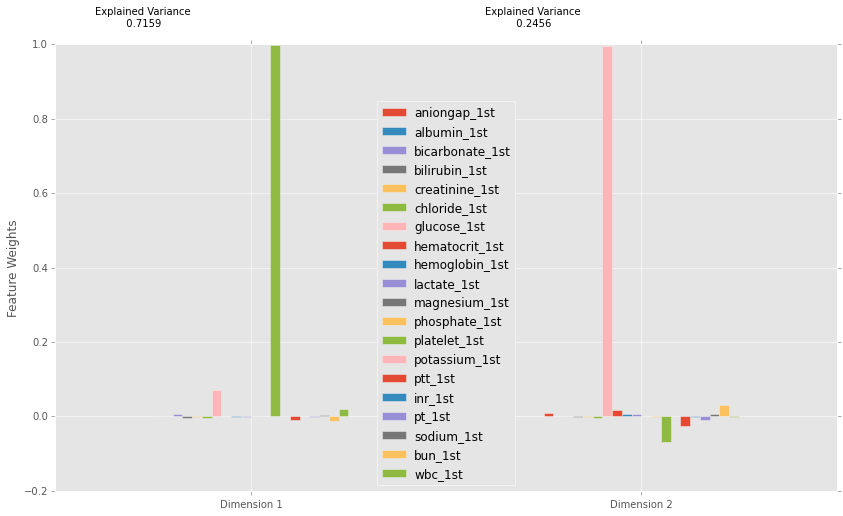

In [102]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 2).fit(good_data[good_data.columns[1:]])
# is this redundant?
#pca.fit(just_measures)
# TODO: Transform log_samples using the PCA fit above

# Generate PCA results plot
pca_results = vs.pca_results(good_data[good_data.columns[1:]], pca)

In [103]:
reduced_data = pca.transform(good_data[good_data.columns[1:]])
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_data.head()

Dimension 1  Dimension 2
0    43.135929    46.112311
1    24.684801   -87.264314
2   -72.001596   -17.011003
3  -121.055464    89.603711
4   -15.363312    33.688936

In [108]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from class_vis import prettyPicture, output_image
X_train, X_test, y_train, y_test = train_test_split(reduced_data, good_data['mort_hosp'], test_size = 0.25, random_state = 42)


### create classifier
clf = GaussianNB()
### fit the classifier on the training features and labels
clf.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf.score(X_test, y_test) 

print nb_score

0.804054054054
